In [247]:
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from math import ceil
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import plotly.express as px

In [2]:
#Reading the data and checking it
data1=pd.read_csv('donors.csv',sep = ',')
data1

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,95407,2016-01-01,ASE,1,AK,99504,,,NaN,0,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,95408,2016-01-01,DCD,1,TX,77379,,,1970-01-01,0,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,95409,2015-01-01,MBC,1,MI,48910,,,1958-01-01,0,...,8.285714,189641,1,L,3,E,X,X,X,B
95410,95410,2006-01-01,PRV,0,CA,91320,,,1960-05-01,0,...,12.146341,4693,1,L,4,F,X,X,X,A


# PRE PROCESSING

In [3]:
data=data1.copy()

# DATA CLEANING AND FEATURE SELECTION

# Personal Info

Here, we will split the data into **different groups of features.** The idea here is to do deeper analysis on each of the groups and do **feature selection based on correlation.**

In [4]:
personal_info=data.loc[:,['GENDER','DOB','WEALTH1','PEPSTRFL','TCODE','HOMEOWNR','HPHONE_D']]
#dropped TCODE,HOMEOWNR
personal_info

,GENDER,DOB,WEALTH1,PEPSTRFL,TCODE,HOMEOWNR,HPHONE_D
0,F,1957-12-01,NaN,X,0,,0
1,M,1972-02-01,9.0,,1,H,0
2,M,NaN,1.0,X,1,U,1
3,F,1948-01-01,4.0,X,0,U,1
4,F,1940-01-01,2.0,,0,H,1
...,...,...,...,...,...,...,...
95407,M,NaN,NaN,,1,,0
95408,M,1970-01-01,9.0,,1,H,1
95409,M,1958-01-01,NaN,X,1,,1
95410,F,1960-05-01,NaN,X,0,H,1


In [5]:
personal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GENDER    95412 non-null  object 
 1   DOB       71529 non-null  object 
 2   WEALTH1   50680 non-null  float64
 3   PEPSTRFL  95412 non-null  object 
 4   TCODE     95412 non-null  int64  
 5   HOMEOWNR  95412 non-null  object 
 6   HPHONE_D  95412 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.1+ MB


In [6]:
#categorical variable
personal_info['GENDER'].value_counts()

F    51277
M    39094
      2957
U     1715
J      365
C        2
A        2
Name: GENDER, dtype: int64

In [7]:
#we drop rows that contain A and C because we can not identify what it means
data.drop(labels = data[data['GENDER']=='A'].index,axis=0,inplace =True)
data.drop(labels = data[data['GENDER']=='C'].index,axis=0,inplace =True)
#we replace spaces and J with Unknown gender because they can be non identified gender
data["GENDER"].replace({' ': 'U', 'J' : 'U'}, inplace=True)
data["GENDER"].replace({'M': 0, 'F' : 1,"U":np.nan}, inplace=True)
data.rename(columns={"GENDER":"GENDER_FEMALE"},inplace=True)

In [8]:
#if we consider we have people from 2000-2017 we do this
data['DOB'] = pd.to_datetime(data['DOB'], format='%Y/%m/%d',errors="coerce") #we are changing into datetime and telling the data to ignore the nan
data.loc[data['DOB'].dt.year >= 2000, 'DOB'] -= pd.DateOffset(years=100)
data['AGE'] = 2017 - data['DOB'].dt.year
data.drop(columns='DOB', inplace = True)

In [9]:
data["AGE"]

0        60.0
1        45.0
2         NaN
3        69.0
4        77.0
         ... 
95407     NaN
95408    47.0
95409    59.0
95410    57.0
95411    79.0
Name: AGE, Length: 95408, dtype: float64

In [10]:
personal_info['WEALTH1'].isnull().value_counts()
#We can see that there are a lot of null values in this feature

False    50680
True     44732
Name: WEALTH1, dtype: int64

In [11]:
personal_info['PEPSTRFL'].value_counts()

     50143
X    45269
Name: PEPSTRFL, dtype: int64

In [12]:
data['PEP_status']= data['PEPSTRFL'].replace({' ' : '0','X':'1'})
data['PEP_status'].value_counts()

0    50141
1    45267
Name: PEP_status, dtype: int64

In [13]:
data=data.drop(columns=['PEPSTRFL'])

In [14]:
#Null values
personal_info['TCODE'].value_counts()
#we can see that 40k data are 0 (non specified), therefore we can drop this line

0        40917
1        25691
2        17006
28        8258
1002      1861
3          835
4          367
28028       71
72          63
980         54
13          45
4002        44
14          22
45          17
116         17
18          17
42          15
22          13
39002       11
24          11
13002        7
30           7
228          5
6            5
136          5
23           5
202          4
21           3
14002        2
6400         2
134          2
9            2
4004         2
94           2
100          2
18002        2
17           2
58002        1
7            1
93           1
50           1
47           1
96           1
44           1
27           1
25           1
40           1
22002        1
38           1
24002        1
72002        1
12           1
76           1
36           1
61           1
Name: TCODE, dtype: int64

In [15]:
data=data.drop(columns=['TCODE'])

In [16]:
personal_info['HOMEOWNR'].value_counts()
#as the number of unknown values and the number of blank values is almost half of the dataset, we will drop this column

H    52354
     22228
U    20830
Name: HOMEOWNR, dtype: int64

In [17]:
data=data.drop(columns=['HOMEOWNR'])
#data=data.drop(columns=['HOMEOWNR','TCODE'])

In [18]:
#change DOB to Age
personal_info['DOB'].isnull().value_counts()

False    71529
True     23883
Name: DOB, dtype: int64

In [19]:
personal_info

,GENDER,DOB,WEALTH1,PEPSTRFL,TCODE,HOMEOWNR,HPHONE_D
0,F,1957-12-01,NaN,X,0,,0
1,M,1972-02-01,9.0,,1,H,0
2,M,NaN,1.0,X,1,U,1
3,F,1948-01-01,4.0,X,0,U,1
4,F,1940-01-01,2.0,,0,H,1
...,...,...,...,...,...,...,...
95407,M,NaN,NaN,,1,,0
95408,M,1970-01-01,9.0,,1,H,1
95409,M,1958-01-01,NaN,X,1,,1
95410,F,1960-05-01,NaN,X,0,H,1


In [20]:
personal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GENDER    95412 non-null  object 
 1   DOB       71529 non-null  object 
 2   WEALTH1   50680 non-null  float64
 3   PEPSTRFL  95412 non-null  object 
 4   TCODE     95412 non-null  int64  
 5   HOMEOWNR  95412 non-null  object 
 6   HPHONE_D  95412 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.1+ MB


Related to Donor's interests

In [21]:
interests=data.loc[:,['COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER','KIDSTUFF','CARDS','PLATES']]
interests

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
0,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,
4,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,,,,,,,,,,,,,,,,,,
95408,,,,,,,,,,,,,,,,,,
95409,,,,,,,,,,,,,,,,,,
95410,,,,,,,,,,,,,,,,,,


In [22]:
#We will drop these columns since it is not going to be used for cliustering, but to study them.
data=data.drop(columns=['COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER','KIDSTUFF','CARDS','PLATES'])

Related to Census
Married status

In [23]:
married=data.loc[:,['MARR1','MARR2','MARR3','MARR4','HHD3','HHD4']]

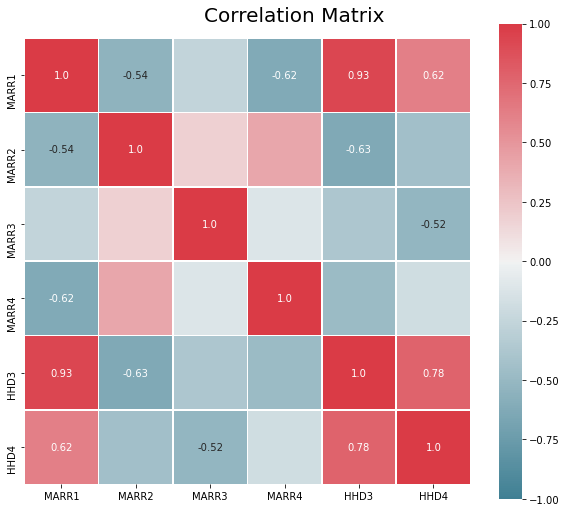

In [24]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(married.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [25]:
#high correlation:MARR1-HHD3, HHD3-HHD4
#we can keep HHD 3 and drop
data=data.drop(columns=['MARR1','HHD4'])

Education - Census

In [26]:
education=data.loc[:,['EC1','EC2','EC3','EC4','EC5','EC6','EC7','EC8','SEC1','SEC2','SEC3','SEC4','SEC5']]

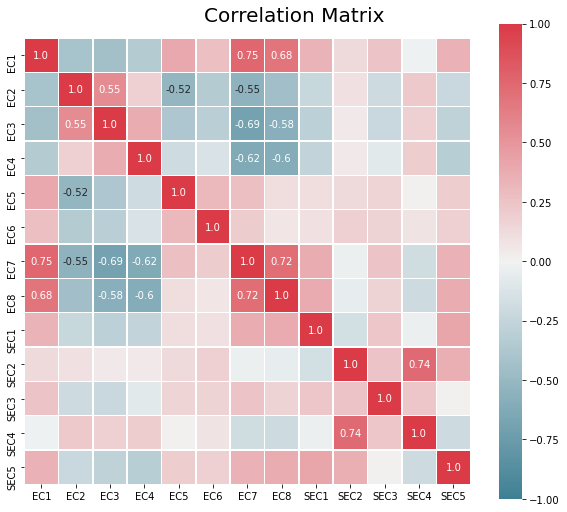

In [27]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(education.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()


In [28]:
#high correlation: EC1-EC7 EC7-EC8 SEC4-SEC2
#we can keep EC7 and SEC2
data=data.drop(columns=['EC1','EC8','SEC4'])

Veterans - Census

In [29]:
veterans=data.loc[:,['AFC1','AFC2','AFC3','AFC4','AFC5','AFC6','VC1','VC2','VC3','VC4','MALEMILI','MALEVET','VIETVETS','WWIIVETS']]

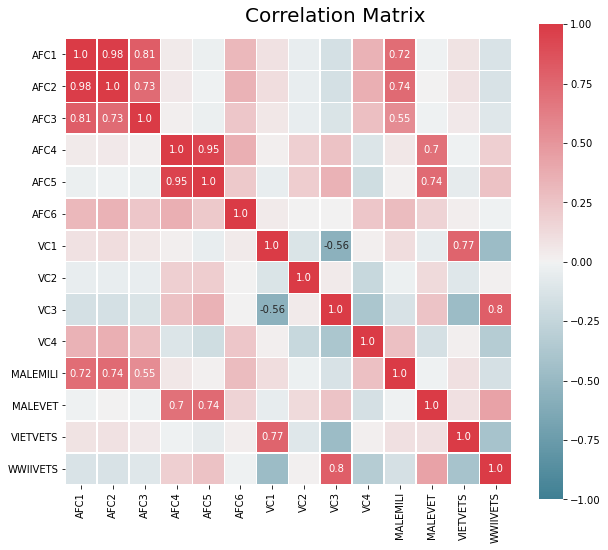

In [30]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(veterans.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [31]:
#high correlation: MALEMILI- AFC1-AFC2-AFC3, AFC4-AFC5-MALEVET, VC3-WWIIVETS, VC1-VIETVETS
#We decide to keep the charactestics given by the State: MALEMILI, MALEVET, afc6
data=data.drop(columns=['AFC1','AFC2','AFC3','AFC4','AFC5','VC1','VC3'])

Work related - Census

In [32]:
labor_force=data.loc[:,['LFC1','LFC2','LFC3','LFC4','LFC5','LFC6','LFC7','LFC8','LFC9','LFC10']]

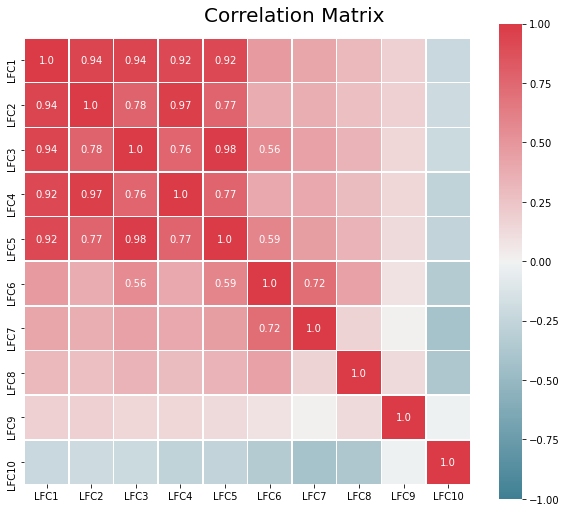

In [33]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(labor_force.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [34]:
#high correlated: LFC1-LFC2-LFC3-LFC4-LFC5
#We can keep LFC1
data=data.drop(columns=['LFC2','LFC3','LFC4','LFC5'])

In [35]:
type_of_job=data.loc[:,['OCC1','OCC2','OCC3','OCC4','OCC5','OCC6','OCC7','OCC8','OCC9','OCC10','OCC11','OCC12','OCC13','PEC1','PEC2',
                       'EIC1','EIC2','EIC3','EIC4','EIC5','EIC6','EIC7','EIC8','EIC9','EIC10','EIC11','EIC12',
                       'EIC13','EIC14','EIC15','EIC16','OEDC4','OEDC5','OEDC6','OEDC7']]

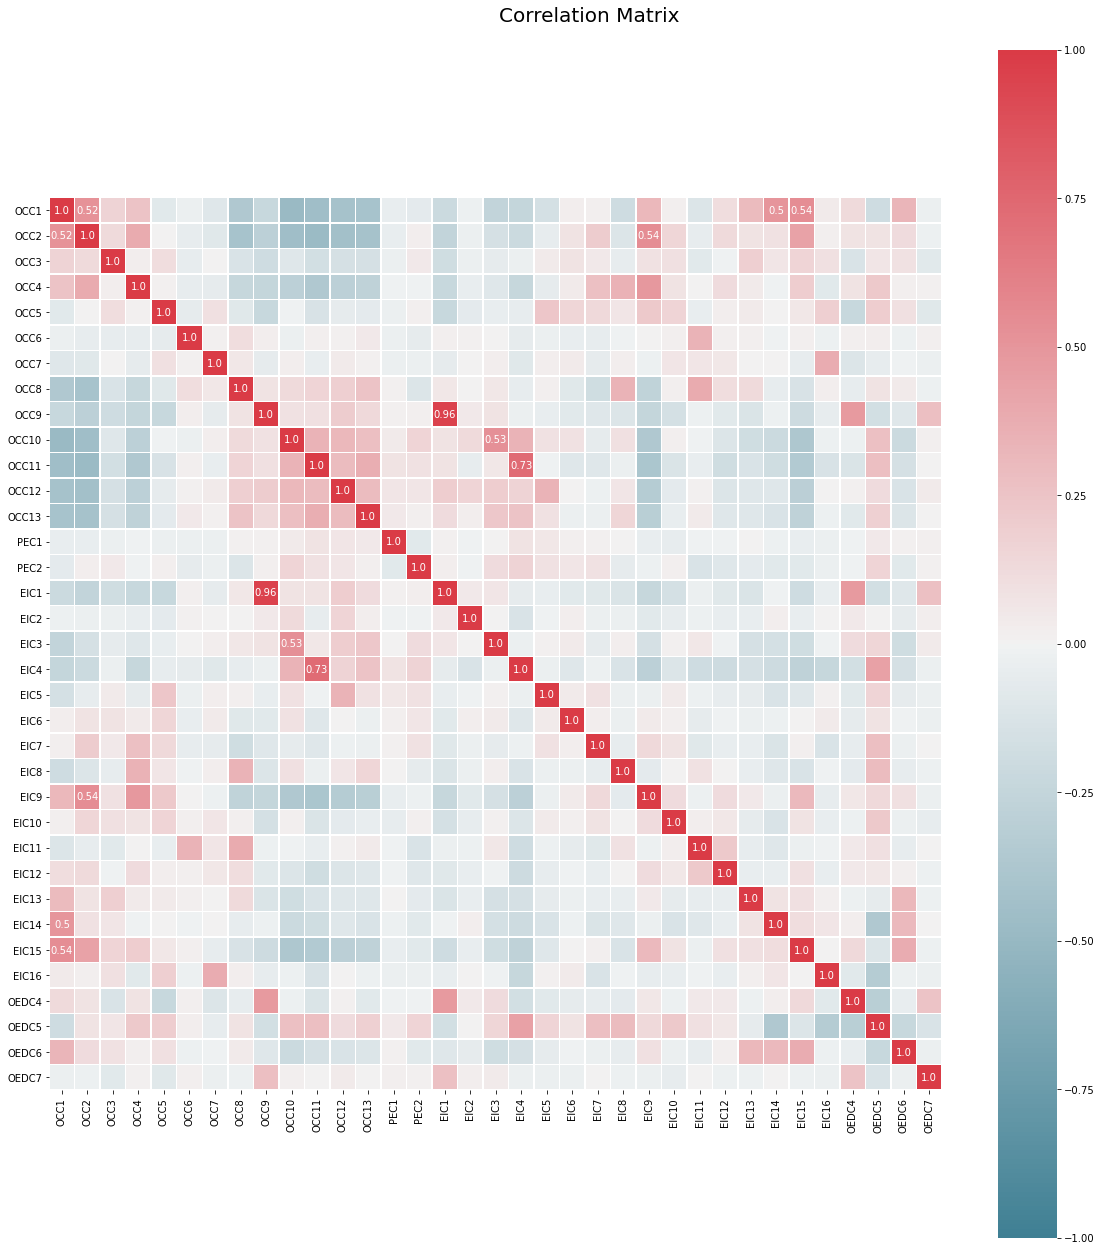

In [36]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(type_of_job.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [37]:
#HIGHLY CORRELATED: EC1-OCC9, EIC4-OCC11
data=data.drop(columns=['OCC9','OCC11'])

In [38]:
state_worker=data.loc[:,['OEDC1','OEDC2','OEDC3','LOCALGOV','STATEGOV','FEDGOV']]

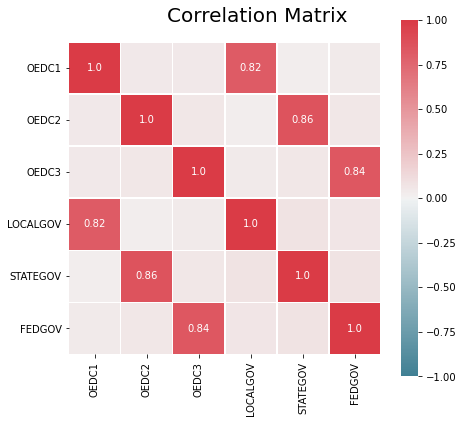

In [39]:
# Prepare figure
fig = plt.figure(figsize=(7, 6))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(state_worker.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [40]:
#KEEP LOCALGOV, STATEGOV, FEDGOV
data=data.drop(columns=['OEDC1','OEDC2','OEDC3'])

In [41]:
transport=data.loc[:,['TPE1','TPE2','TPE3','TPE4','TPE5','TPE6','TPE7','TPE8','TPE9','TPE10','TPE11','TPE12','TPE13']]

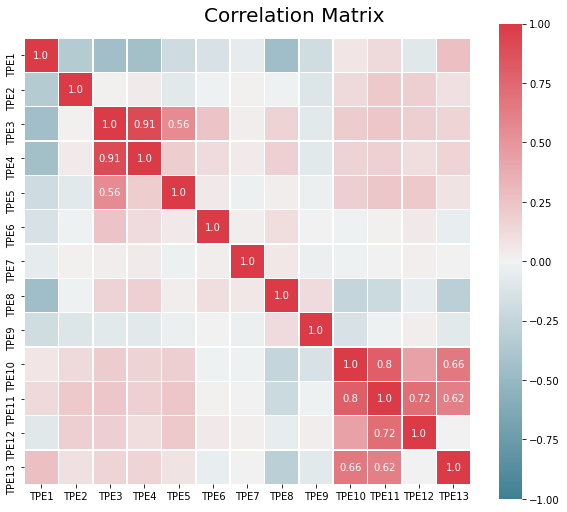

In [42]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(transport.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [43]:
#high correlated: TPE3-TPE4,TPE10-TPE11, TPE11-TPE12
#keep TPE11
data=data.drop(columns=['TPE4','TPE10','TPE12'])

# Neighborhood (Census Data)

In [44]:
household=data.loc[:,['VOC1','VOC2','VOC3','HHAS1','HHAS2','HHAS3','HHAS4']]

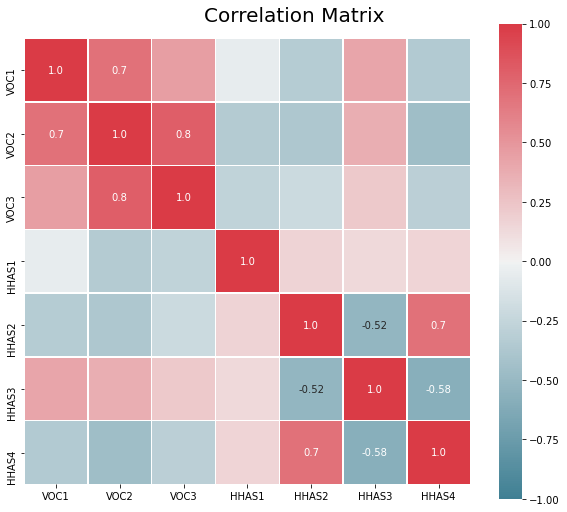

In [45]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(household.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [46]:
#highly correlated: VOC1-VOC2,VOC2-VOC3
#KEEP VOC2,HHAS2
data=data.drop(columns=['VOC1','VOC3','HHAS4'])

In [47]:
children=data.loc[:,['NUMCHLD','CHIL1','CHIL2','CHIL3','CHILC1','CHILC2','CHILC3','CHILC4','CHILC5']]

In [48]:
data=data.drop(columns=['CHILD03','CHILD07','CHILD12','CHILD18'])

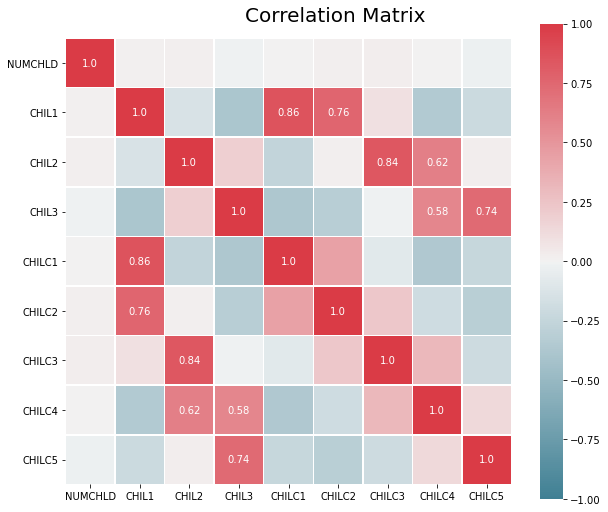

In [49]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(children.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [50]:
#highly correlated: CHIL1-CHILC1-CHILC2, CHIL2-CHILC3,CHIL3-CHILC5,CHIL2-CHILC4
#we will also drop NUMCHLD as it has a lot of null values
#keep CHIL1,CHIL2,CHIL3,
data=data.drop(columns=['NUMCHLD','CHILC1','CHILC2','CHILC3','CHILC4','CHILC5'])

In [51]:
family_wealth=data.loc[:,['INCOME','WEALTH1','WEALTH2','IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14','IC15','IC16','IC17','IC18','IC19','IC20','IC21','IC22','IC23']]

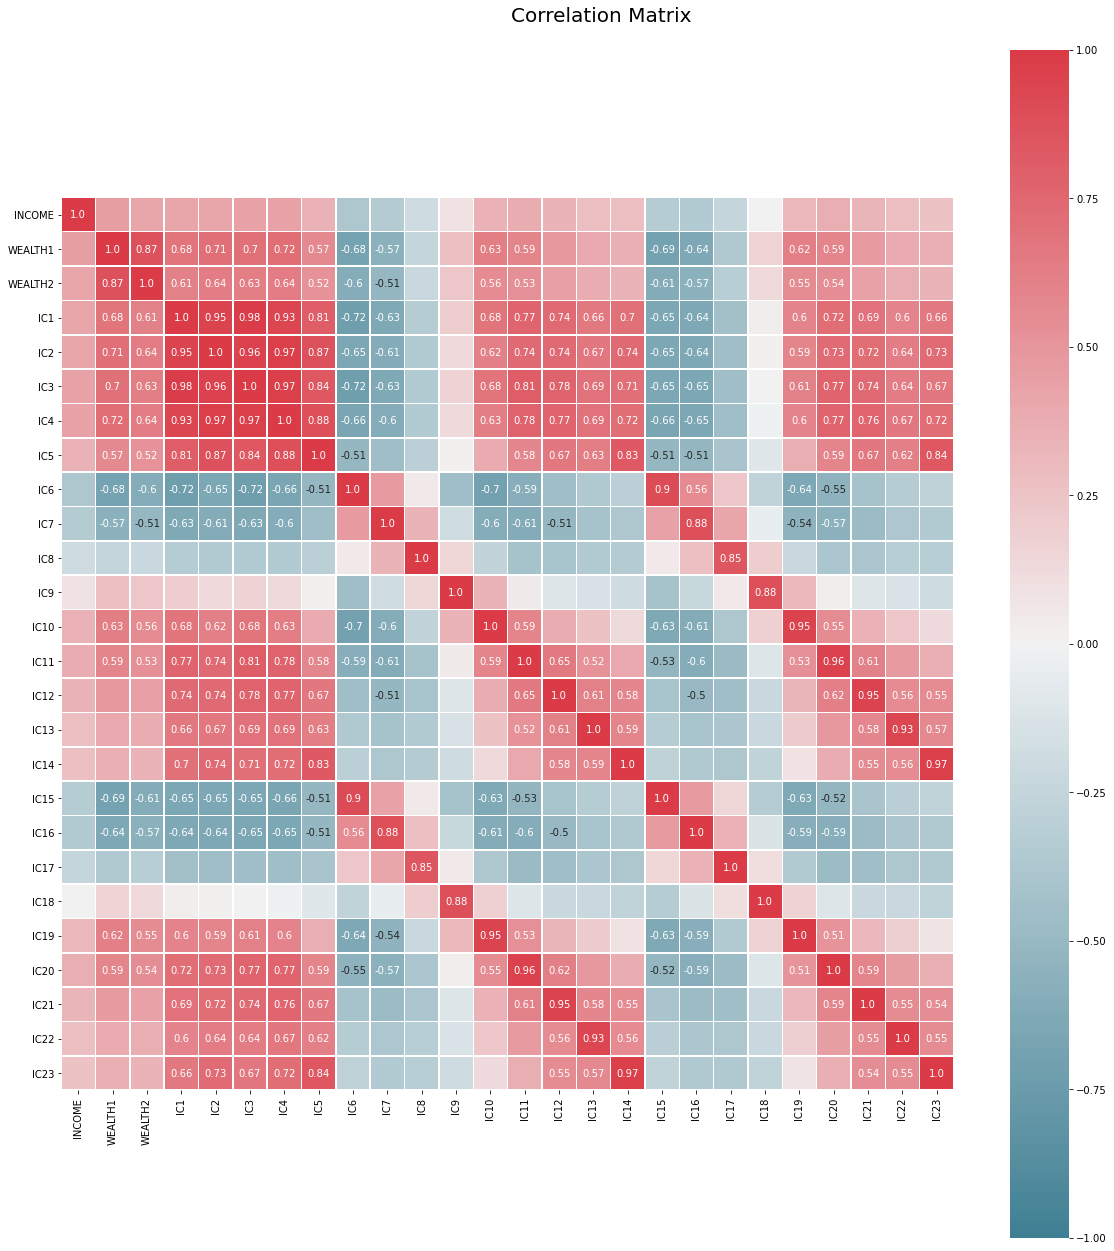

In [52]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(family_wealth.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [53]:
#highly correlated: WEALTH1-WEALTH2, IC1-IC2-IC3-IC4-IC5-IC6-IC11-IC12-IC20, IC6-IC7, IC6-IC15, IC7-IC8, IC7-IC16, 
#IC9-IC18, IC10-IC19, IC13-IC22, IC14-IC23, 
#Keep WEALTH2(Less 0),IC1,IC7,IC9,IC10, IC13,IC14 
data=data.drop(columns=['WEALTH1','IC2','IC3','IC4','IC5','IC6','IC8','IC11','IC12', 'IC16','IC18','IC19','IC20','IC22','IC23'])

In [54]:
people=data.loc[:,['HHAGE1','HHAGE2','HHAGE3','HHN1','HHN2','HHN3','HHN4','HHN5','HHN6','HHP1','HHP2','MC1','MC2','MC3']]

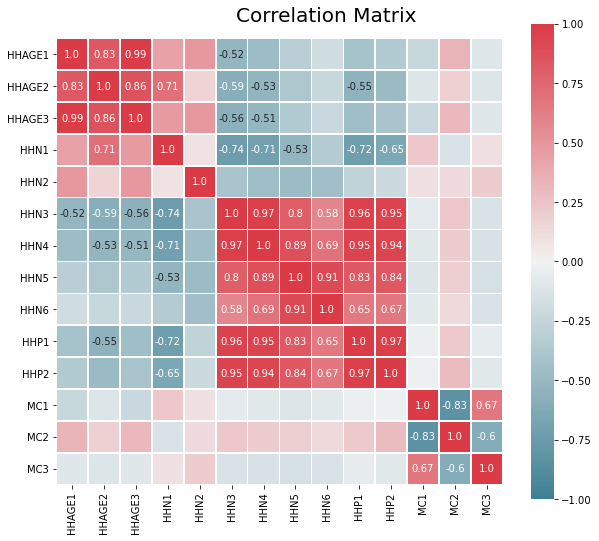

In [55]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(people.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [56]:
#highly correlated: HHAGE1-HHAGE2-HHAGE3, HHN1-HHN3-HHN4-HHP1, HHN3-HHN4-HHN5-HHP1-HHP2, MC1-MC2
#keep HHAGE1, HHN3, HHN6, HHN2
data=data.drop(columns=['HHAGE2','HHAGE3','HHN1','HHN4','HHN5','HHP1','HHP2','MC1'])

In [57]:
occupation_house=data.loc[:,['HU1','HU2','HU3','HU4','HU5','HHD1','HHD2','HHD5','HHD6','HHD7','HHD8','HHD9','HHD10','HHD11','HHD12','HC1','HC2','HC3','HC4','HC5','HC6','HC7','HC8','HC9','HC10','HC11','HC12','HC13','HC14','HC15','HC16','HC17','HC18','HC19','HC20','HC21']]

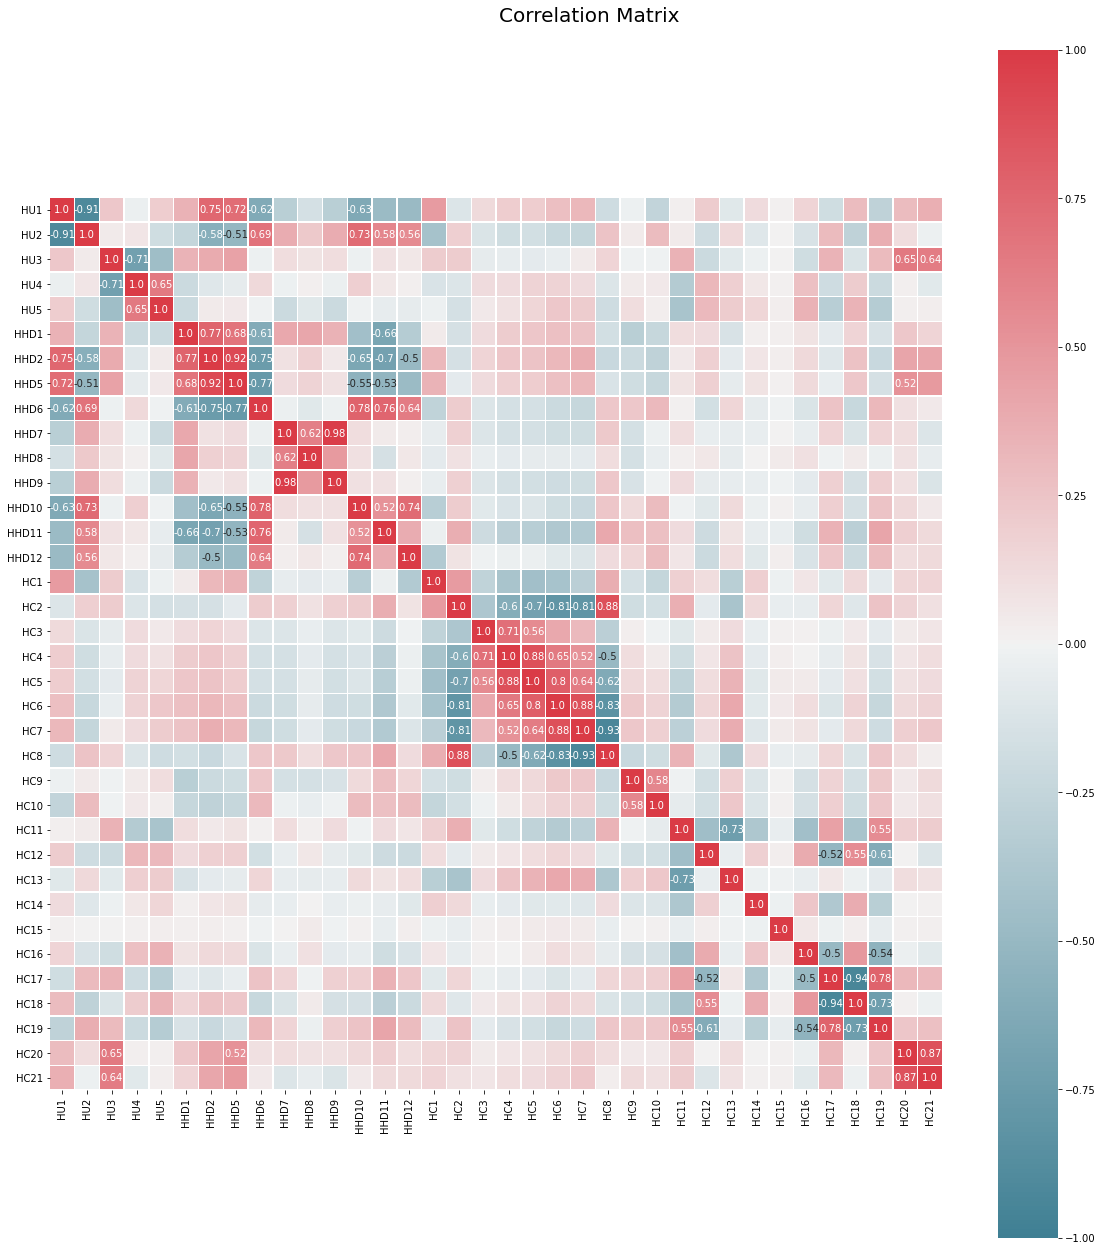

In [58]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(occupation_house.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [59]:
#highly correlated: HU1-HU2-HHD2-HHD5, HU2-HHD10, HHD10-HHD12, HU3-HU4, HHD1-HHD2, HHD2-HHD5-HHD6, HHD6-HHD10, HHD7-HHD9, HC2-HC6-HC7-HC8, HC3-HC4, HC4-HC5, HC5-HC6, HC6-HC7-HC8, HC17-HC18-HC19, HC20-HC21
#KEEP HU1, HHD1, HHD10, HU4, HHD1, HHD9, HC20,HC17, HC6,HC4, 
data=data.drop(columns=['HU2','HU3','HHD2','HHD5','HHD6','HHD7','HHD12','HC2','HC3','HC5','HC7','HC8','HC18','HC19','HC21'])

In [60]:
HUPA=data.loc[:,['HUPA1','HUPA2','HUPA3','HUPA4','HUPA5','HUPA6','HUPA7']]

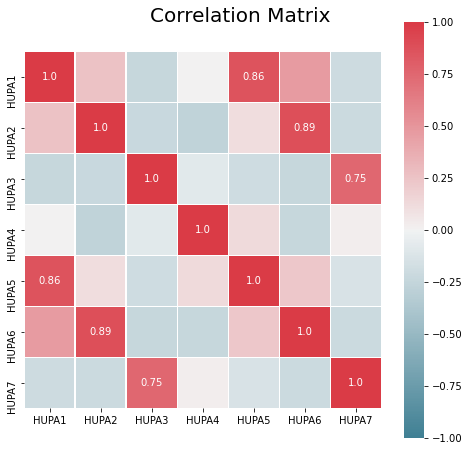

In [61]:
# Prepare figure
fig = plt.figure(figsize=(8, 7))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(HUPA.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [62]:
#highly correlated: HUPA1-HUPA5, HUPA2-HUPA6, HUPA3-HUPA7
#KEEP hupa1, HUPA2,HUPA3, HUPA3,HUPA4
data=data.drop(columns=['HUPA5','HUPA6','HUPA7'])

In [63]:
house_value=data.loc[:,['HVP1','HVP2','HVP3','HVP4','HVP5','HVP6','HV1','HV2','HV3','HV4','MHUC1','MHUC2','RP1','RP2','RP3','RP4']]

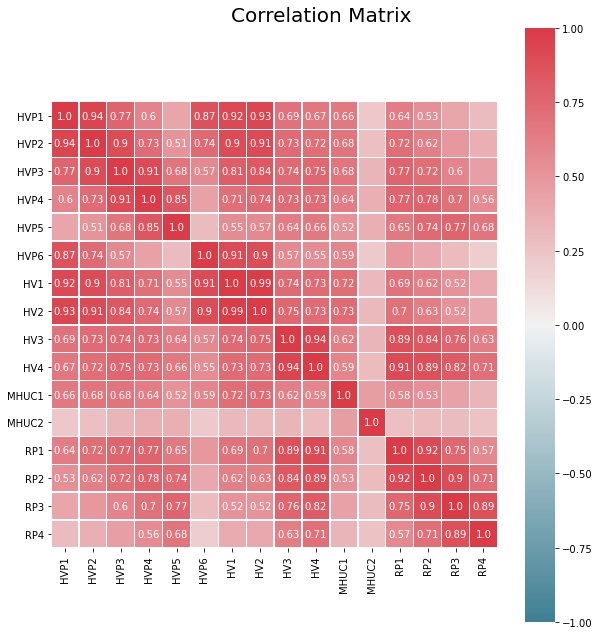

In [64]:
# Prepare figure
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(house_value.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [65]:
#highly correlated: HVP1-HVP2-HVP3-HVP6-HV1-HV2, HVP3-HVP4-HV1-HV2, HVP4-HVP5-HV2, HV3-HV4, MHUC1-HV2, HV4-RP1-RP2-RP3-RP4
#keep HV4,HV2, HVP5, MHUC2
data=data.drop(columns=['HV1','HV3','HVP1','HVP2','HVP3','HVP6','HVP4','MHUC1','RP1','RP2','RP3','RP4'])

In [66]:
house_units=data.loc[:,['DW1','DW2','DW3','DW4','DW5','DW6','DW7','DW8','DW9']]

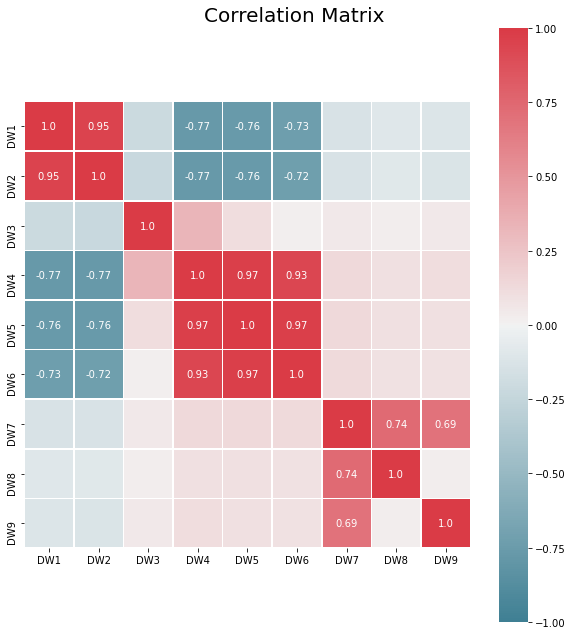

In [67]:
# Prepare figure
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(house_units.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [68]:
#highly correlated: DW1-DW2, dw4-dw5-dw6
#keep DW1,DW4
data=data.drop(columns=['DW2','DW5','DW6'])

In [69]:
rooms=data.loc[:,['HUR1','HUR2','RHP1','RHP2','RHP3','RHP4']]

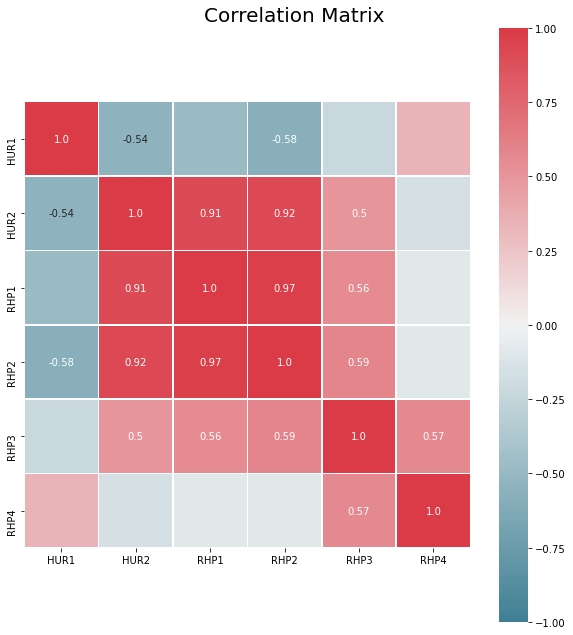

In [70]:
# Prepare figure
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(rooms.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [71]:
#highly correlated: hur2-rhp1-RHP2
#keep rhp2
data=data.drop(columns=['HUR2','RHP1'])

# STATE

In [72]:
state=data.loc[:,['STATE','PVASTATE','GEOCODE','GEOCODE2','ZIP','MSA','ADI','DMA']]

In [73]:
state

,STATE,PVASTATE,GEOCODE,GEOCODE2,ZIP,MSA,ADI,DMA
0,IL,,,C,61081,0.0,177.0,682.0
1,CA,,02,A,91326,4480.0,13.0,803.0
2,NC,,,C,27017,0.0,281.0,518.0
3,CA,,,C,95953,9340.0,67.0,862.0
4,FL,,,A,33176,5000.0,127.0,528.0
...,...,...,...,...,...,...,...,...
95407,AK,,,C,99504,380.0,0.0,743.0
95408,TX,,,A,77379,3360.0,201.0,618.0
95409,MI,,,B,48910,4040.0,61.0,551.0
95410,CA,,04,A,91320,8735.0,13.0,803.0


In [74]:
state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95408 entries, 0 to 95411
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     95408 non-null  object 
 1   PVASTATE  95408 non-null  object 
 2   GEOCODE   95408 non-null  object 
 3   GEOCODE2  95276 non-null  object 
 4   ZIP       95408 non-null  object 
 5   MSA       95276 non-null  float64
 6   ADI       95276 non-null  float64
 7   DMA       95276 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.6+ MB


In [75]:
#IDEA: we could draw the US map to see the numbers better (we should install geopandas on jupiter)

In [76]:
data['PVASTATE'].value_counts()
#93954 null values, DROP COLUMN

     93950
P     1453
E        5
Name: PVASTATE, dtype: int64

In [77]:
data['GEOCODE'].value_counts()
#drop column: 80168 null values

      80165
12     3914
03     3327
14     2017
05     1918
04     1622
02     1408
01     1037
Name: GEOCODE, dtype: int64

In [78]:
data['GEOCODE2'].value_counts()

A    34481
B    28505
D    16579
C    15524
       187
Name: GEOCODE2, dtype: int64

In [79]:
data=data.drop(columns=['PVASTATE','GEOCODE'])

In [80]:
#we need to understand if ZIP column is the same one as STATE
data['ZIP'].value_counts()

85351     61
92653     59
85710     54
95608     50
92037     45
          ..
76635      1
75754      1
54666      1
93005-     1
75082-     1
Name: ZIP, Length: 19938, dtype: int64

In [81]:
data_state=data.loc[:,['STATE','ZIP','GEOCODE2']]
data_state

,STATE,ZIP,GEOCODE2
0,IL,61081,C
1,CA,91326,A
2,NC,27017,C
3,CA,95953,C
4,FL,33176,A
...,...,...,...
95407,AK,99504,C
95408,TX,77379,A
95409,MI,48910,B
95410,CA,91320,A


In [82]:
#we want to check if the zipcodes are exactly corresponding to the State. We use the zipcodes excel file from the site
#https://simplemaps.com/data/us-zips to check this
zipfile=pd.read_excel('uszips.xlsx')

In [83]:
#we will just consider these columns for this check
zipfile1=zipfile[['zip','state_id','state_name']].copy()
zipfile1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33097 entries, 0 to 33096
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   zip         33097 non-null  int64 
 1   state_id    33097 non-null  object
 2   state_name  33097 non-null  object
dtypes: int64(1), object(2)
memory usage: 775.8+ KB


In [84]:
data_state["ZIP"][data_state["ZIP"].str.match("93527-")]

25    93527-
Name: ZIP, dtype: object

In [85]:
data_state["ZIP"][9]=37127

In [86]:
#data_state["ZIP"]=data_state["ZIP"].astype(int)

In [87]:
#merge=pd.merge(data_state,zipfile1,how='inner', left_on='ZIP',right_on='zip')
#we lost 7774 rows, but just for the purpose of checking if the zipcodes are exactly the same as the states we will not consider these rows

In [88]:
#(merge.STATE == merge.state_id).value_counts()
#considering only  0.0045 of my data is false, we can consider that the states correspond to the zipcode
#Therefore I can drop this column in the dataset data

In [89]:
data=data.drop(columns=['ZIP'])

In [90]:
data['GEOCODE2'].replace({'A': 1, 'B': 2, 'C': 3, 'D':4}, inplace=True)

# Neighborhood

In [91]:
neighborhood=data.loc[:,['DOMAIN','POP901','POP902','POP903','POP90C1','POP90C2','POP90C3','POP90C4','POP90C5']]

In [92]:
neighborhood['Urbanicity_level'] = neighborhood['DOMAIN'].str[0]
#U=Urban
#C=City
#S=Suburban
#T=Town
# R=Rural

neighborhood['SocioEconomic_status'] = neighborhood['DOMAIN'].str[1]
#1 = Highest SES
#2 = Average SES
#3 = Lowest SES 
#(except for Urban communities, where
#1 = Highest SES, 
#2 = Above average SES,
#3 = Below average SES, 4 = Lowest SES.)

#we can now drop the DOMAIN column
data= data.drop(columns='DOMAIN')


In [93]:
data['Urbanicity_level']=neighborhood['Urbanicity_level']
data['SocioEconomic_status'] = neighborhood['SocioEconomic_status']

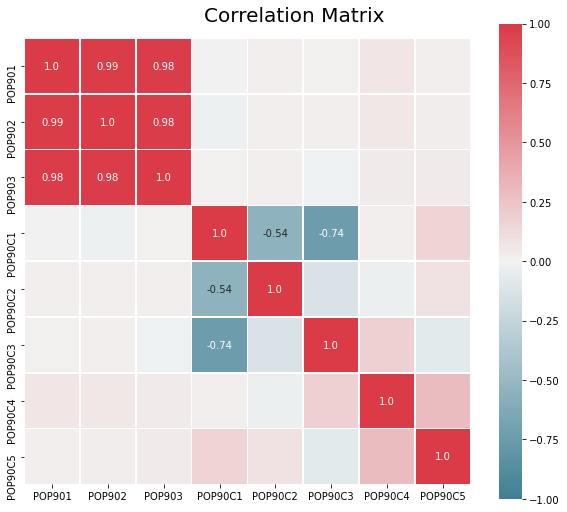

In [94]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(neighborhood.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [95]:
#highly correlated: POP901-POP902-POP903, POP90C3-POP90C1
data=data.drop(columns=['POP902','POP903','POP90C3'])

In [96]:
races_neighbour=data.loc[:,['ETH1','ETH2','ETH3','ETH4' , 'ETH5','ETH6', 'ETH7','ETH8','ETH9'  
,'ETH10','ETH11','ETH12' ,'ETH13' ,'ETH14' ,'ETH15','ETH16', 'ETHC1','ETHC2','ETHC3','ETHC4','ETHC5','ETHC6' ]]
            

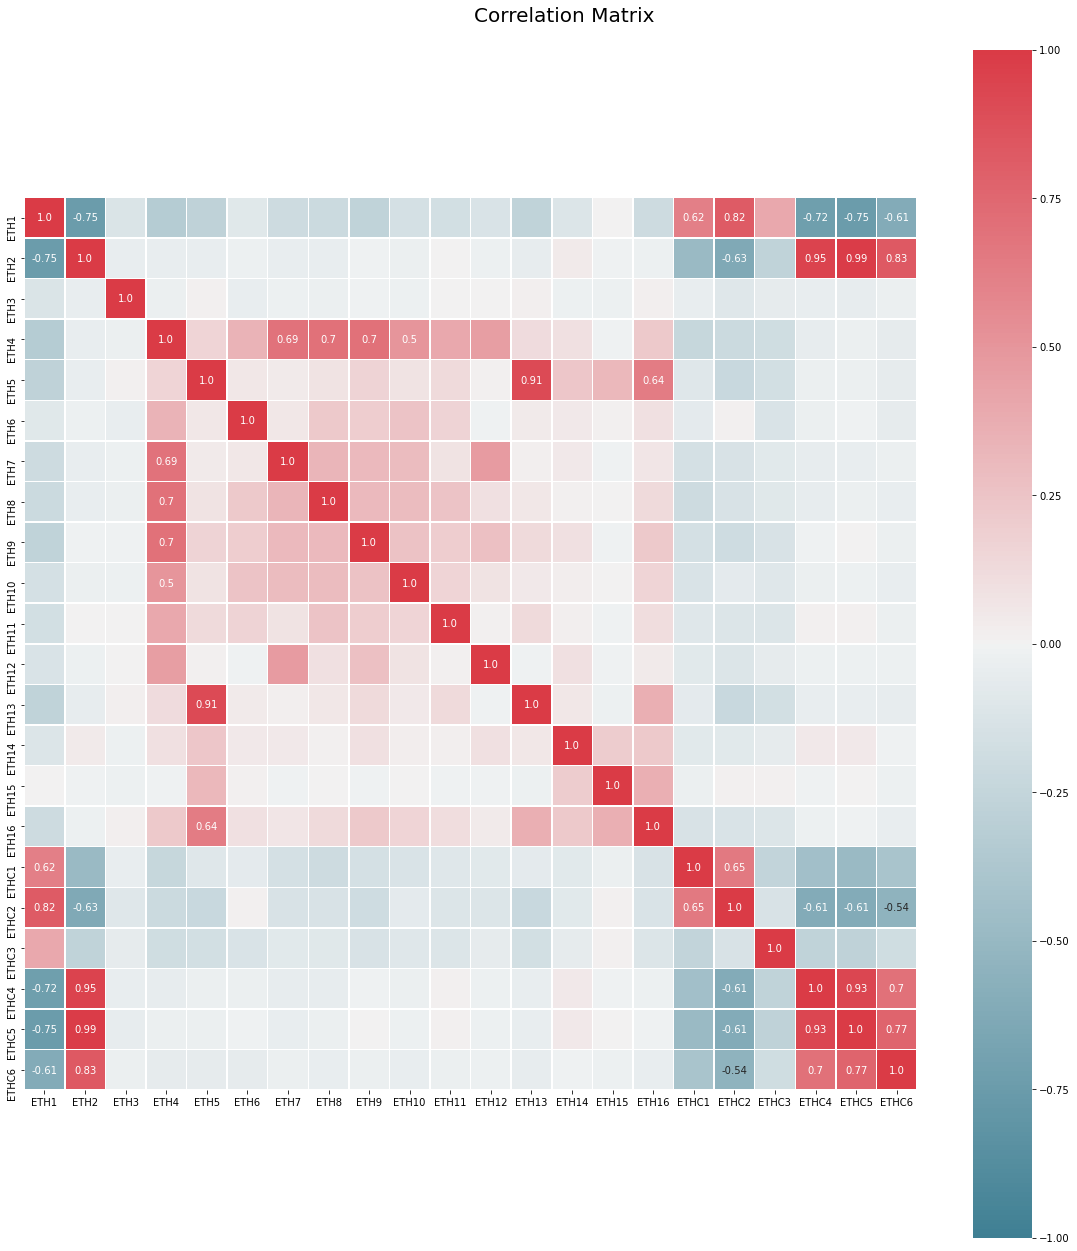

In [97]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(races_neighbour.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [98]:
#HIGHLY CORRELATED ETH2-ETCH4-ETCH5-ETCH6, ETH1-ETCH2
data=data.drop(columns=['ETHC4','ETHC5','ETHC6'])

In [99]:
sum1=data[['ETHC1','ETHC2','ETHC3']]
races_neighbour['WHITE']=sum1.sum(axis=1)

In [100]:
races_neighbour[['WHITE','ETH1']]

,WHITE,ETH1
0,92,92
1,67,67
2,95,96
3,62,61
4,2,2
...,...,...
95407,79,78
95408,91,91
95409,81,82
95410,91,92


In [101]:
races_neighbour['difference_white']=races_neighbour['WHITE'] - races_neighbour['ETH1']

In [102]:
races_neighbour['difference_white'].value_counts()

 0    62572
 1    18221
-1    14444
 2      171
Name: difference_white, dtype: int64

In [103]:
#as the difference is not big we keep ETH1 and drop the other columns
data=data.drop(columns=['ETHC1','ETHC2','ETHC3'])
#we group the different ethnicities by continent
to_sum=data[['ETH6','ETH7','ETH8','ETH9','ETH10','ETH11','ETH12']]
races_neighbour['eth_asian']=to_sum.sum(axis=1)

In [104]:
races_neighbour[['eth_asian','ETH4']]

,eth_asian,ETH4
0,0,0
1,30,31
2,0,0
3,8,11
4,0,0
...,...,...
95407,2,4
95408,2,2
95409,0,1
95410,4,5


In [105]:
races_neighbour['difference1']=races_neighbour['eth_asian'] - races_neighbour['ETH4']
races_neighbour['difference1'].value_counts()

 0     53072
-1     31803
-2      6576
 1      1352
-3      1315
-4       492
-5       236
-6       125
-7       117
-8        66
-9        52
-10       26
-11       26
-12       22
 2        19
-15       16
-13       15
-14       12
-16        8
-19        8
-18        7
-24        7
-20        6
-22        6
-23        5
-21        5
-32        2
-43        2
-25        1
-26        1
-27        1
-31        1
-35        1
-38        1
-45        1
-47        1
-49        1
-17        1
Name: difference1, dtype: int64

In [106]:
#In here there are some differences, therefore I will keep the column we created and drop the rest
data=data.drop(columns=['ETH4','ETH6','ETH7','ETH8','ETH9','ETH10','ETH11','ETH12'])

In [107]:
data['eth_asian']=races_neighbour['eth_asian']
to_sum2=data[['ETH13','ETH14','ETH15','ETH16']]
races_neighbour['eth_south_america']=to_sum2.sum(axis=1)
races_neighbour[['eth_south_america','ETH5']]

,eth_south_america,ETH5
0,11,11
1,7,6
2,2,2
3,32,32
4,0,1
...,...,...
95407,6,5
95408,6,6
95409,9,9
95410,8,8


In [108]:
races_neighbour['difference']=races_neighbour['eth_south_america'] - races_neighbour['ETH5']
races_neighbour['difference'].value_counts()

 0    64865
-1    23533
 1     6870
-2      112
 2       28
Name: difference, dtype: int64

In [109]:
#since the difference is not large, we can keep the column ETH5 and drop all the others
data=data.drop(columns=['ETH13','ETH14','ETH15','ETH16'])

In [110]:
races_neighbour2=data.loc[:,['ETH1','ETH2','ETH3','ETH5', 'eth_asian','POBC1','POBC2','LSC1','LSC2','LSC3','LSC4']]

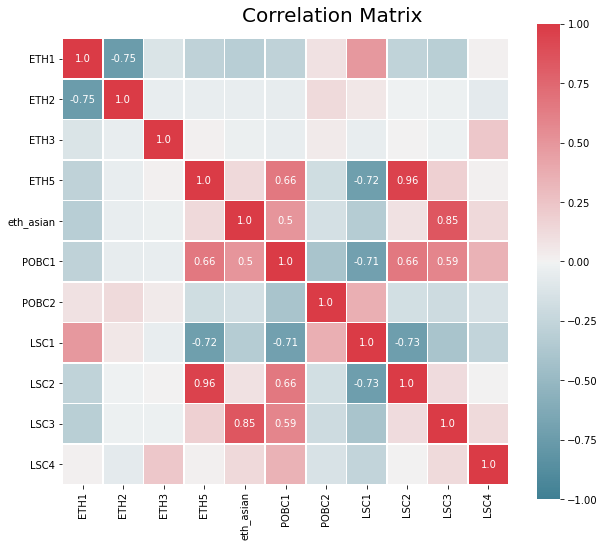

In [111]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(races_neighbour2.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [112]:
#HIGHLY CORRELATED: ETH5-LSC2, eth_asian-LSC3
data=data.drop(columns=['LSC2','LSC3'])

In [113]:
age=data.loc[:,['AC1','AC2','AGE901','AGE902','AGE903','AGE904','AGE905','AGE906','AGE907','AGEC1','AGEC2','AGEC3','AGEC4','AGEC5','AGEC6','AGEC7']]

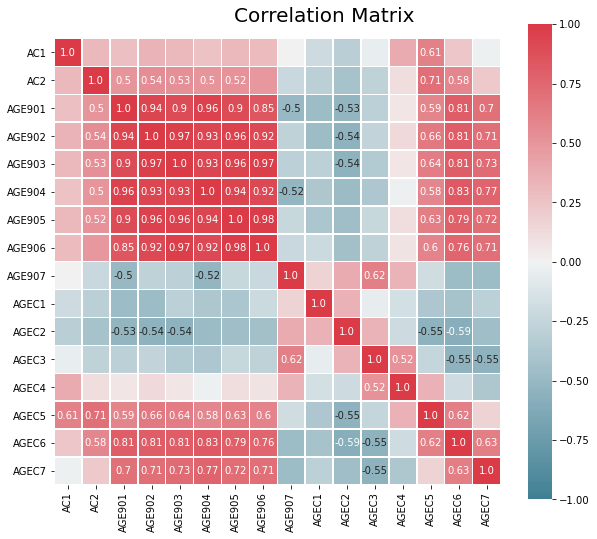

In [114]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(age.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [115]:
#highly correlated: AGE901-AGE902-AGE903-AGE904-AGE905-AGE906-AGEC6, AGE904-AGEC7-AGEC6
#KEEP AGE904, AGE907
data=data.drop(columns=['AGE901','AGE902','AGE903','AGE905','AGE906','AGEC7','AGEC6'])

In [116]:
between_55_64=data[['AC1','AC2']]
age['between_55_64']=between_55_64.sum(axis=1)

In [117]:
age[['between_55_64','AGEC5']]

,between_55_64,AGEC5
0,17,13
1,11,10
2,11,13
3,12,12
4,18,20
...,...,...
95407,7,8
95408,5,7
95409,14,9
95410,9,12


In [118]:
age['diff']=age['AGEC5']-age['between_55_64']
age['diff'].value_counts()

 0     22829
 1     15425
-1     14435
 2      9153
-2      8028
       ...  
-37        1
-36        1
 29        1
-35        1
-32        1
Name: diff, Length: 69, dtype: int64

In [119]:
#as the difference is really small we will keep AGEC5 and drop the rest
data=data.drop(columns=['AC1','AC2'])

In [120]:
ancient=data.loc[:,['ANC1','ANC2','ANC3','ANC4','ANC5','ANC6','ANC7','ANC8','ANC9','ANC10','ANC11','ANC12','ANC13','ANC14','ANC15']]

# Related to Mails

In [121]:
mail_related=data.loc[:,['OSOURCE','MAILCODE','CONTROLN','NOEXCH']]

In [122]:
mail_related

,OSOURCE,MAILCODE,CONTROLN,NOEXCH
0,GRI,,95515,0
1,BOA,,148535,0
2,AMH,,15078,0
3,BRY,,172556,0
4,,,7112,0
...,...,...,...,...
95407,ASE,,184568,0
95408,DCD,,122706,0
95409,MBC,,189641,0
95410,PRV,,4693,0


In [123]:
mail_related.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95408 entries, 0 to 95411
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   OSOURCE   95408 non-null  object
 1   MAILCODE  95408 non-null  object
 2   CONTROLN  95408 non-null  int64 
 3   NOEXCH    95408 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


In [124]:
#mailing lists
#don't really know the meaning
data['OSOURCE'].value_counts()

MBC    4539
SYN    3563
AML    3430
BHG    3324
IMP    2986
       ... 
HSL       1
GFT       1
RCS       1
ESM       1
HRT       1
Name: OSOURCE, Length: 896, dtype: int64

In [125]:
mail_related['MAILCODE'].value_counts()
#this column has a lot of zeros and it's not relevant for our research


     94009
B     1399
Name: MAILCODE, dtype: int64

In [126]:
data=data.drop(columns=['MAILCODE'])

In [127]:
data['CONTROLN']
#WE COULD PUT THIS AS INDEX, BUT AS THIS IS NOT USEFUL FOR OUR ANALYSIS WE WILL DROP THIS COLUMN

0         95515
1        148535
2         15078
3        172556
4          7112
          ...  
95407    184568
95408    122706
95409    189641
95410      4693
95411    185114
Name: CONTROLN, Length: 95408, dtype: int64

In [128]:
data=data.drop(columns=['CONTROLN'])

In [129]:
data['NOEXCH'].value_counts()
#as we have a lot of 0 values, we can drop this column

0    61200
0    33881
1      195
1       90
X       35
         7
Name: NOEXCH, dtype: int64

In [130]:
data=data.drop(columns=['NOEXCH'])

In [131]:
#we have several columns that are related to mail responses
#we are going to pu them all together 

In [132]:
mail=data.loc[:,['HIT','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE','PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP']]

In [133]:
mail

,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,60,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95408,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95409,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95410,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
mail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95408 entries, 0 to 95411
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HIT       95408 non-null  int64  
 1   MBCRAFT   42555 non-null  float64
 2   MBGARDEN  42555 non-null  float64
 3   MBBOOKS   42555 non-null  float64
 4   MBCOLECT  42495 non-null  float64
 5   MAGFAML   42555 non-null  float64
 6   MAGFEM    42555 non-null  float64
 7   MAGMALE   42555 non-null  float64
 8   PUBGARDN  42555 non-null  float64
 9   PUBCULIN  42555 non-null  float64
 10  PUBHLTH   42555 non-null  float64
 11  PUBDOITY  42555 non-null  float64
 12  PUBNEWFN  42555 non-null  float64
 13  PUBPHOTO  42555 non-null  float64
 14  PUBOPP    42555 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 14.1 MB


In [135]:
mail_sum=data.loc[:,['HIT','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE','PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP']]
mail['sum_mail'] = mail_sum.sum(axis=1)

In [136]:
mail

,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,sum_mail
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,16,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,27.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,60,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
95408,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
95409,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
95410,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [137]:
#we add the column to data and remove all columns
data['mail_replies']=mail['sum_mail']
data=data.drop(columns=['HIT','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE','PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP'])

# GIVING HISTORY FILE

In [138]:
#Converting DATES into a datetime dtype and creating variables days since first donation and days since last donation
data['ODATEDW'] =  pd.to_datetime(data['ODATEDW'])
data['LASTDATE'] =  pd.to_datetime(data['LASTDATE'])
data['FISTDATE'] =  pd.to_datetime(data['FISTDATE'])
data["DAYS_FIRST"]=(datetime(2017,12,31)-data["FISTDATE"]).dt.days
data["DAYS_LAST"]=(datetime(2017,12,31)-data["LASTDATE"]).dt.days
data.drop(columns=["LASTDATE","FISTDATE"],inplace=True)

In [139]:
#analyse first column:
data['ODATEDW'].value_counts()

2015-01-01    15358
2006-01-01    14595
2014-01-01    12065
2016-01-01    10122
2011-01-01     8551
2010-01-01     7717
2012-01-01     7539
2008-01-01     6669
2009-01-01     5342
2013-01-01     3921
2007-01-01     3451
2017-01-01       15
2015-09-01        4
2012-09-01        4
2014-10-01        3
2015-10-01        3
2012-12-01        3
2013-02-01        2
2010-09-01        2
2015-06-01        2
2009-10-01        2
2013-09-01        2
2012-02-01        2
2009-12-01        2
2005-01-01        2
2011-09-01        2
2013-10-01        2
2008-10-01        1
2009-09-01        1
2008-04-01        1
2007-04-01        1
2004-01-01        1
2007-02-01        1
2015-12-01        1
2013-12-01        1
2006-12-01        1
2006-11-01        1
2010-03-01        1
2006-08-01        1
2010-12-01        1
2012-05-01        1
2013-03-01        1
2011-03-01        1
2007-11-01        1
2006-09-01        1
2014-02-01        1
2015-11-01        1
2007-07-01        1
2006-04-01        1
2003-06-01        1


In [140]:
#I want to create 2 columns to show the year and the month of the first time they gave money to the association
data['Month_first_gift'] = pd.DatetimeIndex(data['ODATEDW']).month
data['Year_first_gift'] = pd.DatetimeIndex(data['ODATEDW']).year
data=data.drop(columns=['ODATEDW'])

In [141]:
#we find the total number of money every donor gave to the association, related to promotions
donations_from_promotions=data.loc[:,['RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24']]
donations_from_promotions

,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,...,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0
1,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,...,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,...,NaN,9.0,NaN,8.0,NaN,NaN,NaN,8.0,7.0,6.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,...,NaN,7.0,11.0,NaN,NaN,6.0,11.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95408,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95409,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,5.0,NaN,NaN
95410,NaN,15.0,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,...,18.0,18.0,NaN,15.0,NaN,NaN,15.0,20.0,NaN,NaN


In [142]:
donations_from_promotions['Money_donated_from_promotions'] = donations_from_promotions.sum(axis=1)


In [143]:
donations_from_promotions

,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,...,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,Money_donated_from_promotions
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0,73.0
1,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,...,9.0,NaN,8.0,NaN,NaN,NaN,8.0,7.0,6.0,58.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,...,7.0,11.0,NaN,NaN,6.0,11.0,NaN,NaN,NaN,65.0
4,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
95408,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
95409,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,...,NaN,NaN,10.0,NaN,NaN,NaN,5.0,NaN,NaN,35.0
95410,NaN,15.0,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,...,18.0,NaN,15.0,NaN,NaN,15.0,20.0,NaN,NaN,157.0


In [144]:
data['Money_donated_from_promotions'] = donations_from_promotions['Money_donated_from_promotions']


In [145]:
#now we can drop all the columns we don't need
data=data.drop(columns=['RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24'])

In [146]:
#in here we have 
#RAMNTALL = Dollar amount of lifetime gifts to date
#NGIFTALL = Number of lifetime gifts to date
#CARDGIFT = Number of lifetime gifts to card promotions to date

data[['Money_donated_from_promotions','CARDGIFT','RAMNTALL','NGIFTALL','AVGGIFT','MINRAMNT','MAXRAMNT','LASTGIFT','DAYS_LAST','DAYS_FIRST','NEXTDATE','TIMELAG']]

,Money_donated_from_promotions,CARDGIFT,RAMNTALL,NGIFTALL,AVGGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,DAYS_LAST,DAYS_FIRST,NEXTDATE,TIMELAG
0,73.0,14,240.0,31,7.741935,5.0,12.0,10.0,761,2982.0,2010-03-01,4.0
1,37.0,1,47.0,3,15.666667,10.0,25.0,25.0,761,1552.0,2015-04-01,18.0
2,58.0,14,202.0,27,7.481481,2.0,16.0,5.0,761,2921.0,2011-01-01,12.0
3,65.0,7,109.0,16,6.812500,2.0,11.0,10.0,761,3986.0,2007-11-01,9.0
4,25.0,8,254.0,37,6.864865,3.0,15.0,15.0,730,6880.0,2000-05-01,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95407,25.0,0,25.0,1,25.000000,25.0,25.0,25.0,699,699.0,NaN,NaN
95408,20.0,0,20.0,1,20.000000,20.0,20.0,20.0,670,670.0,NaN,NaN
95409,35.0,4,58.0,7,8.285714,3.0,10.0,10.0,456,1187.0,2015-01-01,3.0
95410,157.0,18,498.0,41,12.146341,5.0,21.0,18.0,364,4048.0,2007-04-01,4.0


In [147]:
#we substitute AVGGIFT with a new column calculating the average manually since we can not trust the data completely
data['Average_money_donated']=data['RAMNTALL'].div(data.NGIFTALL, axis=0).round(2)

In [148]:
gifts=data[['Money_donated_from_promotions','CARDGIFT','RAMNTALL','NGIFTALL','Average_money_donated','MINRAMNT','MAXRAMNT','LASTGIFT','DAYS_LAST','DAYS_FIRST','NEXTDATE','TIMELAG']]

In [149]:
data=data.drop(columns=['AVGGIFT'])

In [150]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95408 entries, 0 to 95411
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Money_donated_from_promotions  95408 non-null  float64
 1   CARDGIFT                       95408 non-null  int64  
 2   RAMNTALL                       95408 non-null  float64
 3   NGIFTALL                       95408 non-null  int64  
 4   Average_money_donated          95408 non-null  float64
 5   MINRAMNT                       95408 non-null  float64
 6   MAXRAMNT                       95408 non-null  float64
 7   LASTGIFT                       95408 non-null  float64
 8   DAYS_LAST                      95408 non-null  int64  
 9   DAYS_FIRST                     95406 non-null  float64
 10  NEXTDATE                       85435 non-null  object 
 11  TIMELAG                        85435 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usag

In [151]:
data["MAJOR"].replace({' ': 0, "X": 1}, inplace=True)

In [152]:
data['RECINHSE'].value_counts()
#we will replace the space and the Xs with 0 and 1

     88707
X     6701
Name: RECINHSE, dtype: int64

In [153]:
data["RECINHSE"].replace({' ': 0, "X": 1}, inplace=True)

In [154]:
data['SOLIH'].value_counts()
#null values mean we can email them.
#can we just consider solicit or not solicit(0)?

      89210
12     5691
00      296
01       94
02       75
03       19
04       16
06        7
Name: SOLIH, dtype: int64

In [155]:
data['RECP3'].value_counts()
#we will replace the space and the Xs with 0 and 1

     93392
X     2016
Name: RECP3, dtype: int64

In [156]:
data["RECP3"].replace({' ': 0, "X": 1}, inplace=True)

In [157]:
data['SOLP3'].value_counts()

      95228
00       80
12       72
01       18
02       10
Name: SOLP3, dtype: int64

In [158]:
data['RECPGVG'].value_counts()

     95294
X      114
Name: RECPGVG, dtype: int64

In [159]:
data["RECPGVG"].replace({' ': 0, "X": 1}, inplace=True)

In [160]:
data['RECSWEEP'].value_counts()

     93791
X     1617
Name: RECSWEEP, dtype: int64

In [161]:
data["RECSWEEP"].replace({' ': 0, "X": 1}, inplace=True)

In [162]:
data['MDMAUD_A'].value_counts()

X    95116
C      248
L       22
M       17
T        5
Name: MDMAUD_A, dtype: int64

In [163]:
prova=data[['MDMAUD_A','MAJOR']]

In [164]:
prova.groupby(by='MDMAUD_A').sum()
#We checked if the MDMAUD_A contained any non major donors
#the info is coherent

,MAJOR
MDMAUD_A,
C,248
L,22
M,17
T,5
X,0


In [165]:
#we will drop columns related to RFM analysis
data=data.drop(columns=['MDMAUD_R','MDMAUD_F','MDMAUD'])

In [166]:
promotions=data.loc[:,['CARDPROM','NUMPROM','CARDGIFT','NGIFTALL']]

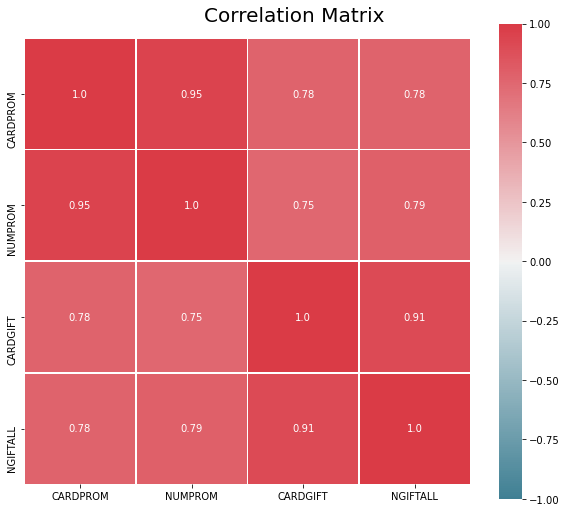

In [167]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(promotions.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [168]:
data=data.drop(columns=['CARDPROM','CARDGIFT'])

In [169]:
data['DATASRCE'] = data['DATASRCE'].replace(r'^\s*$', np.nan, regex=True)

In [170]:
#We create 2 new columns to see who was linked to Polk, who to metromail
data['DATASRCE_polk']= data['DATASRCE'].replace({'1' : '0','2':'1','3':'1'})
data['DATASRCE_metromail']=data['DATASRCE'].replace({'2':'0','3': '1'})
#We can also drop the column DATASRCE
data=data.drop(columns=['DATASRCE','LIFESRC'])


In [171]:
data[['DATASRCE_polk','DATASRCE_metromail']]

,DATASRCE_polk,DATASRCE_metromail
0,NaN,NaN
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
95407,NaN,NaN
95408,1,1
95409,NaN,NaN
95410,1,0


In [172]:
data_source=data.loc[:,['DATASRCE_polk','DATASRCE_metromail','MALEMILI','MALEVET','VIETVETS','WWIIVETS','LOCALGOV','STATEGOV','FEDGOV']]
data_source
#there is no relationship among these percentages, therefore we will just assume that 
#individuals are similar if they have similar percentages


,DATASRCE_polk,DATASRCE_metromail,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV
0,NaN,NaN,0,39,34,18,10,2,1
1,1,1,0,15,55,11,6,2,1
2,1,1,0,20,29,33,6,8,1
3,1,1,0,23,14,31,3,0,3
4,1,1,1,28,9,53,26,3,2
...,...,...,...,...,...,...,...,...,...
95407,NaN,NaN,14,36,47,11,7,8,13
95408,1,1,0,31,43,19,4,1,0
95409,NaN,NaN,0,18,46,20,7,23,0
95410,1,0,0,28,35,20,9,1,1


In [173]:
#we will drop all dates related to promotions as we want to understand the type of donors
data=data.drop(columns=['ADATE_2','ADATE_3','ADATE_4','ADATE_5','ADATE_6','ADATE_7','ADATE_8','ADATE_9','ADATE_10','ADATE_11','ADATE_12','ADATE_13','ADATE_14','ADATE_15','ADATE_16','ADATE_17','ADATE_18','ADATE_19','ADATE_20','ADATE_21','ADATE_22','ADATE_23','ADATE_24'])

In [174]:
data=data.drop(columns=['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24'])

In [175]:
data=data.drop(columns=['RFA_2F','RFA_2A','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12','RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22','RFA_23','RFA_24'])

In [176]:
data=data.drop(columns=['Unnamed: 0'])

In [177]:
data['LASTGIFT'].value_counts()

15.00     17776
20.00     15838
10.00     14256
25.00     10148
5.00       4949
          ...  
137.00        1
24.95         1
26.61         1
104.00        1
25.21         1
Name: LASTGIFT, Length: 231, dtype: int64

In [178]:
#Here we have all of the features that we selected as the ones for clustering
selected_features=["RAMNTALL","INCOME","Average_money_donated","Money_donated_from_promotions","NGIFTALL","DAYS_FIRST","DAYS_LAST","AGE","NUMPROM","PEP_status","GENDER_FEMALE","MAJOR"]

In [179]:
data["PEP_status"]=data["PEP_status"].astype(int)

In [180]:
data[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95408 entries, 0 to 95411
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RAMNTALL                       95408 non-null  float64
 1   INCOME                         74123 non-null  float64
 2   Average_money_donated          95408 non-null  float64
 3   Money_donated_from_promotions  95408 non-null  float64
 4   NGIFTALL                       95408 non-null  int64  
 5   DAYS_FIRST                     95406 non-null  float64
 6   DAYS_LAST                      95408 non-null  int64  
 7   AGE                            71526 non-null  float64
 8   NUMPROM                        95408 non-null  int64  
 9   PEP_status                     95408 non-null  int64  
 10  GENDER_FEMALE                  90371 non-null  float64
 11  MAJOR                          95408 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 12.0 MB


In [181]:
data['INCOME'].isnull().value_counts()

False    74123
True     21285
Name: INCOME, dtype: int64

# MODELING

In [182]:
data_central = data.copy()

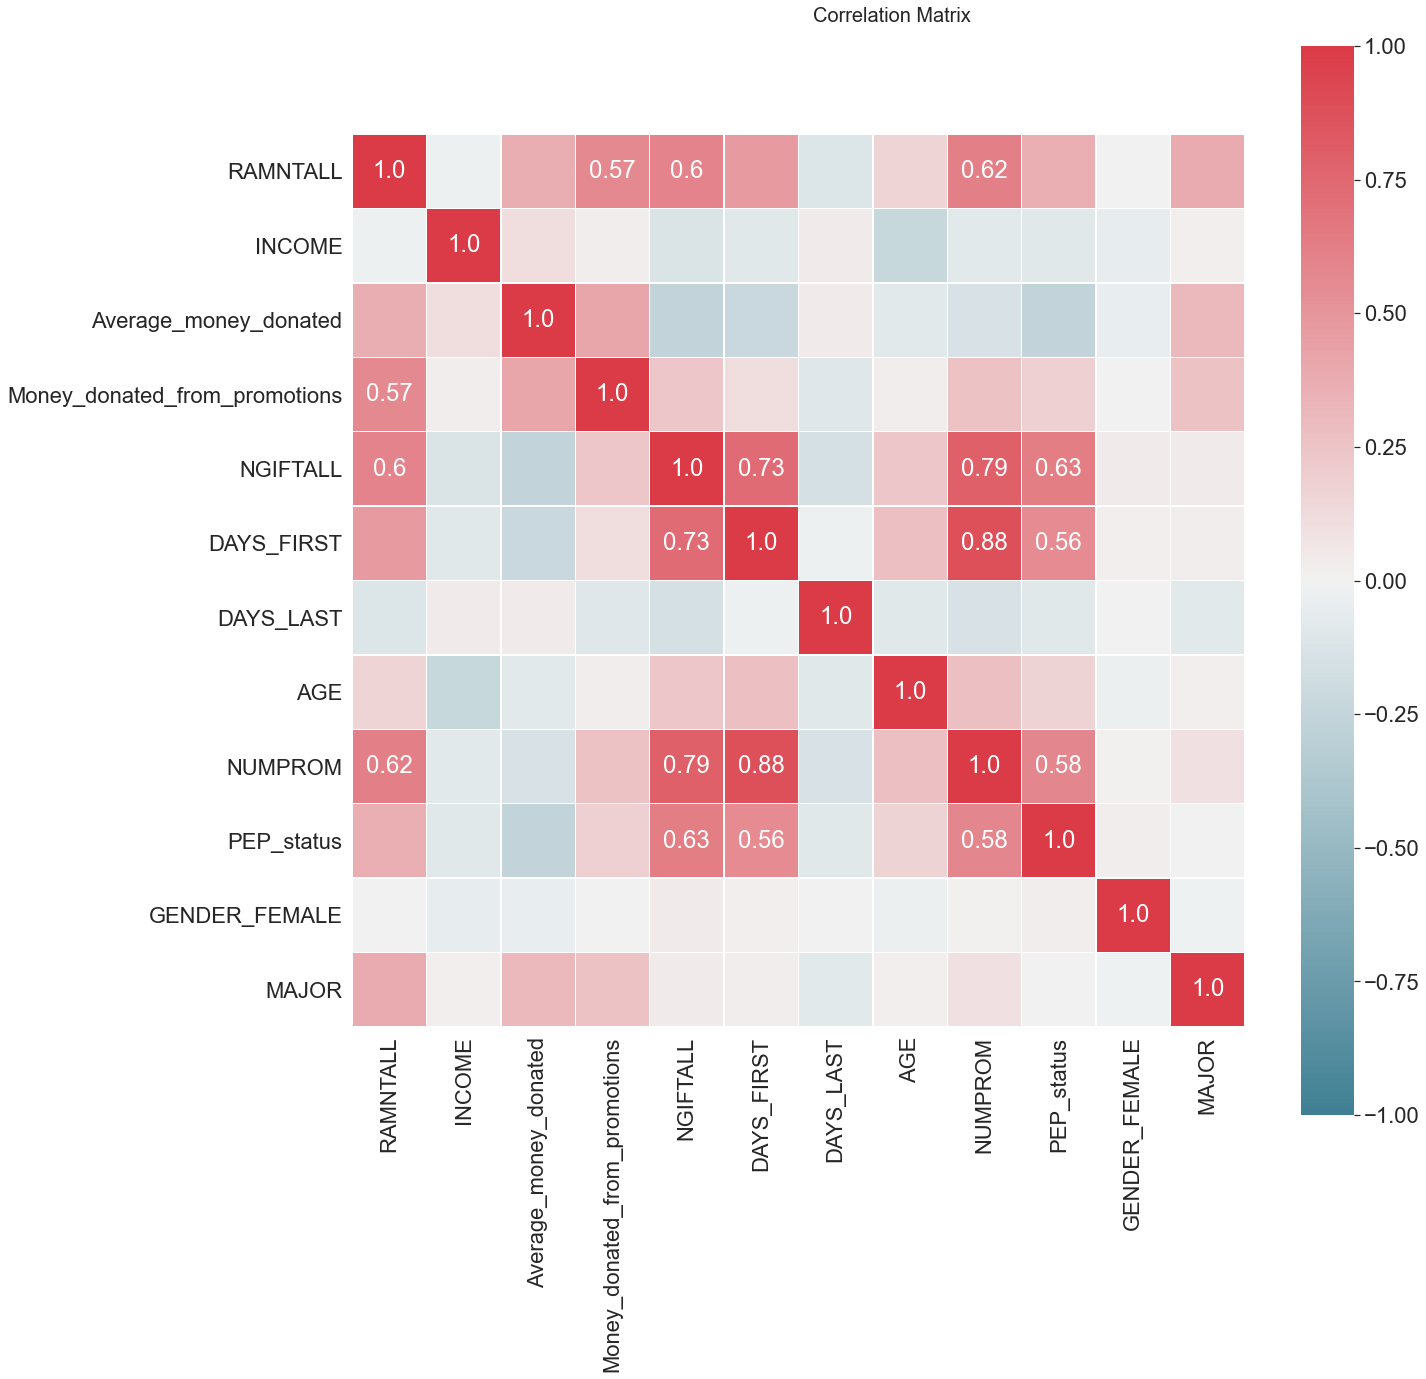

In [183]:
# Prepare figure
sns.set(font_scale=2)
fig = plt.figure(figsize=(20, 18))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data_central[selected_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [184]:
selected_features.remove("NUMPROM")

In [185]:
selected_features

['RAMNTALL',
 'INCOME',
 'Average_money_donated',
 'Money_donated_from_promotions',
 'NGIFTALL',
 'DAYS_FIRST',
 'DAYS_LAST',
 'AGE',
 'PEP_status',
 'GENDER_FEMALE',
 'MAJOR']

# Missing Values for Metric Features (Not included Census Data)

In [186]:
data_central[selected_features].isna().sum()

RAMNTALL                             0
INCOME                           21285
Average_money_donated                0
Money_donated_from_promotions        0
NGIFTALL                             0
DAYS_FIRST                           2
DAYS_LAST                            0
AGE                              23882
PEP_status                           0
GENDER_FEMALE                     5037
MAJOR                                0
dtype: int64

In [187]:
startTime = datetime.now()
imputer = KNNImputer(n_neighbors=5, weights="uniform")
data_central[selected_features] = imputer.fit_transform(data_central[selected_features])
df_pca = data_central.copy()
print(datetime.now() - startTime)
#This cell took 4 minutes to run on a i7 MacBook Pro

0:04:13.460302


# Outliers

In [188]:
df_pca = data_central.copy()

In [189]:
len(data_central)

95408

In [190]:
lof = LocalOutlierFactor(n_neighbors=20)

In [192]:
y_predic=lof.fit_predict(df_pca[selected_features])

In [193]:
df_pca['outliers_labels']=y_predic

In [194]:
outliers= df_pca[df_pca['outliers_labels']==-1]
outliers #this represents 3% of the dataset

,OSOURCE,STATE,RECINHSE,RECP3,RECPGVG,RECSWEEP,INCOME,GENDER_FEMALE,MALEMILI,MALEVET,...,mail_replies,DAYS_FIRST,DAYS_LAST,Month_first_gift,Year_first_gift,Money_donated_from_promotions,Average_money_donated,DATASRCE_polk,DATASRCE_metromail,outliers_labels
26,ESN,IL,0,0,0,0,7.0,1.0,0,32,...,0.0,761.0,761.0,1,2016,50.0,50.00,1,0,-1
54,AGR,IL,0,0,0,0,2.0,0.0,0,31,...,0.0,1613.0,883.0,1,2013,36.0,9.80,1,0,-1
118,,TX,1,0,0,0,7.0,0.0,0,42,...,2.0,5327.0,364.0,1,2009,45.0,41.42,1,1,-1
180,IMA,WA,0,0,0,0,7.0,1.0,0,45,...,3.0,1552.0,761.0,1,2014,0.0,14.00,1,1,-1
278,GPS,TX,0,0,0,0,5.0,1.0,0,32,...,4.0,1460.0,975.0,1,2014,0.0,37.50,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95097,AML,KS,1,0,0,0,6.0,0.0,0,0,...,0.0,3652.0,609.0,1,2008,22.0,6.00,1,0,-1
95251,FRC,FL,0,0,0,0,5.4,1.0,0,26,...,0.0,1217.0,914.0,1,2015,300.0,116.67,NaN,NaN,-1
95262,ADD,CO,0,0,0,0,1.0,1.0,0,21,...,0.0,730.0,730.0,1,2016,25.0,25.00,1,0,-1
95323,MBC,GA,0,0,0,0,5.0,1.0,0,26,...,0.0,852.0,852.0,1,2016,25.0,25.00,1,0,-1


In [199]:
len(outliers)/len(df_pca)

0.03264351891938696

In [197]:
df_pca.drop(outliers.index,inplace=True)

# Reducing Dimensionality

In [200]:
scaler = RobustScaler()
scaled_feat = scaler.fit_transform(df_pca[selected_features])
scaled_feat
df_pca[selected_features]=scaled_feat

In [201]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca[selected_features])
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.643344,0.000000,0.358378,0.358378
2,1.768178,-0.875165,0.239725,0.598104
3,0.934571,-0.833608,0.126707,0.724810
4,0.568669,-0.365901,0.077099,0.801909
5,0.507101,-0.061568,0.068752,0.870661
6,0.359846,-0.147255,0.048787,0.919448
7,0.231755,-0.128090,0.031421,0.950869
8,0.152465,-0.079291,0.020671,0.971539
9,0.114708,-0.037757,0.015552,0.987091
10,0.093102,-0.021606,0.012623,0.999714


PCA

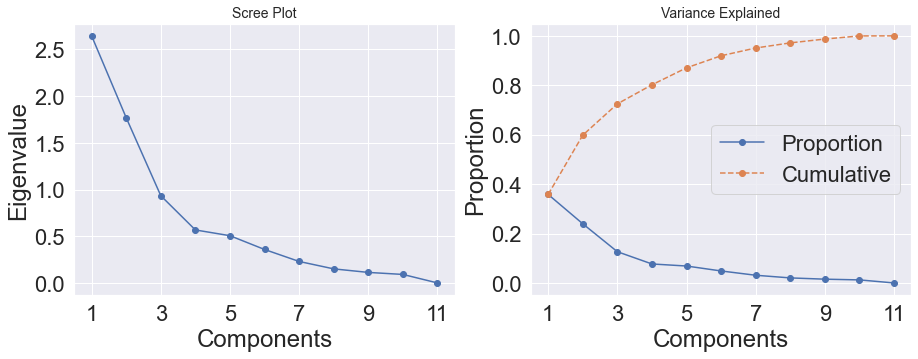

In [202]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [203]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=7)
pca_feat = pca.fit_transform(df_pca[selected_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
0,2.202583,-1.741786,0.402965,-0.852758,0.381772,-0.006073,0.406541
1,-0.710246,1.100083,-0.309681,-0.609602,0.647994,-0.136413,-0.526473
2,1.493585,-1.751780,0.299995,-0.107674,-0.206496,0.019376,-0.610658
3,0.691490,-1.355283,0.083914,-0.172017,-1.396523,0.218791,0.323902
4,1.600990,-2.969068,0.480594,1.259590,0.775378,0.143165,0.390335
...,...,...,...,...,...,...,...
95406,-0.590299,-1.918739,-0.267597,-0.642389,1.235828,0.148712,0.406473
95407,-0.734668,2.011228,-0.953529,0.686898,0.267526,0.126815,-0.509997
95408,-1.113377,1.617076,-1.129726,-0.165611,1.250181,-0.320495,-0.450952
95409,-0.485065,-0.715237,-2.601824,-0.239277,-0.033125,0.029132,-0.575464


In [204]:
df_pca_together=pd.concat([df_pca, pca_df], axis=1)

In [205]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca_together[selected_features + pca_feat_names].corr().loc[selected_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
RAMNTALL,0.926864,-0.179749,0.114028,0.140371,0.173361,0.086035,-0.005611
INCOME,-0.007360,0.236850,0.022740,-0.440634,0.730681,-0.460169,0.058311
Average_money_donated,0.435214,0.840815,-0.031860,0.278236,0.090668,0.025600,0.010908
Money_donated_from_promotions,0.832044,0.208781,-0.041644,-0.398980,-0.307128,-0.085872,-0.000618
NGIFTALL,0.562789,-0.737769,0.126591,0.040848,0.127929,0.064538,-0.002875
DAYS_FIRST,0.421162,-0.630384,0.228760,0.183545,0.156092,-0.036861,-0.013219
DAYS_LAST,-0.179181,0.209851,0.956831,-0.036101,-0.077983,-0.024390,-0.001453
AGE,0.184928,-0.323688,-0.020006,0.518269,-0.320673,-0.693555,0.071912
PEP_status,0.361931,-0.593520,0.114676,-0.089289,0.022390,0.013435,-0.006493
GENDER_FEMALE,-0.007764,-0.060584,0.017058,-0.032998,-0.041900,0.159100,0.983679


# Clustering Using K Means

In [206]:
range_clusters = range(1, 30)

In [207]:
range_clusters = range(1, 30)
startTime = datetime.now()
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(pca_df)
    inertia.append(kmclust.inertia_)  
print(datetime.now() - startTime)
#This cell took 4,5 minutes to run on a i7 MacBook Pro

0:04:37.450467


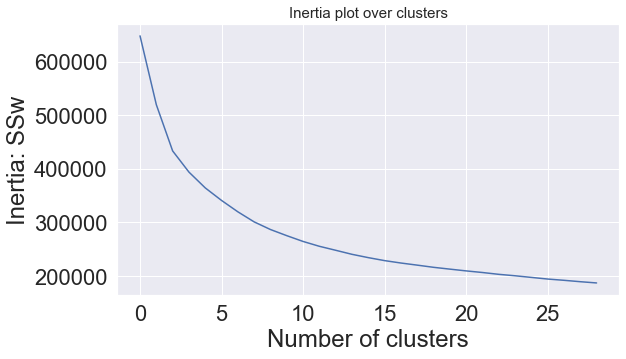

In [208]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [209]:
# final cluster solution
number_clusters = 15
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(pca_df)
km_labels

array([8, 4, 8, ..., 9, 5, 6], dtype=int32)

In [210]:
df_pca.drop("outliers_labels",axis=1,inplace=True)

In [211]:
df_concat = pd.concat((pca_df, pd.Series(km_labels, name='labels')), axis=1)

# Inserting the Outliers back to the Data by Decision Tree

In [212]:
outliers.drop("outliers_labels",axis=1,inplace=True)

In [213]:
scaler = RobustScaler()
scaled_feat2 = scaler.fit_transform(outliers[selected_features])
outliers[selected_features]=scaled_feat2

In [214]:
pca = PCA(n_components=7)
pca_feat2 = pca.fit_transform(outliers[selected_features])
pca_feat_names2 = [f"PC{i}" for i in range(pca.n_components_)]
pca_df2 = pd.DataFrame(pca_feat2, index=outliers.index, columns=pca_feat_names2)  # remember index=df_pca.index
pca_df2

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
26,0.147931,1.916599,1.782124,0.161480,0.912225,0.030209,-0.261480
54,-1.026233,-0.091263,-0.406398,-0.598767,0.538220,0.979037,0.047244
118,20.722963,-10.892175,-3.279835,0.529682,0.294137,-0.606495,-2.280972
180,-1.507113,-1.429352,0.733842,-0.102524,0.690463,0.400359,-0.597747
278,-0.693364,-0.821872,2.037272,0.763763,0.070503,1.196854,0.408306
...,...,...,...,...,...,...,...
95097,-0.600971,-1.668521,-2.401534,1.670464,-0.430996,-0.021860,-1.345862
95251,11.175082,11.482612,-1.543310,-0.664401,0.210471,0.910490,0.595477
95262,-1.340207,0.339048,1.164841,-0.397443,0.264909,-0.472545,-0.065604
95323,-1.342331,0.359352,1.236000,-0.441481,0.418320,0.414742,0.152608


In [215]:
X=pca_df

In [216]:
y=km_labels

In [217]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,stratify=y)

In [218]:
model=DecisionTreeClassifier().fit(X_train,y_train)
model.score(X_val,y_val)

0.9154716164294605

In [219]:
startTime = datetime.now()
model2=RandomForestClassifier().fit(X_train,y_train)
print(model2.score(X_val,y_val))
print(datetime.now() - startTime)
#This cell took 13 seconds to run on a i7 MacBook Pro

0.9575734617674116
0:00:15.036791


In [220]:
startTime = datetime.now()
model3=GradientBoostingClassifier().fit(X_train,y_train)
print(model3.score(X_val,y_val))
print(datetime.now() - startTime)
#This cell took 4 minutes to run on a i7 MacBook Pro

0.9512419503219871
0:04:10.074223


In [221]:
labels_outliers=model2.predict(pca_df2)

In [222]:
data_central2=df_pca.append(outliers)

In [223]:
labels2=np.append(km_labels,labels_outliers)

In [224]:
data_central["labels"]=labels2

In [225]:
data_central["marketing_segmentation"]=data_central["labels"]
data_central["marketing_segmentation"].replace({0:2,1:1,2:3,3:3,4:1,5:2,6:2,7:3,8:1,9:2,10:3,11:3,12:1,13:3,14:1},inplace=True)

In [226]:
data_central.to_csv("data.preprocessed5.csv")

In [227]:
data=data_central.copy()

# GRAPHICAL ANALYSIS

Here we only have the plots used on the report. All other variables were analyzed on different plots but excluded in the final version of this notebook for file size limitations.

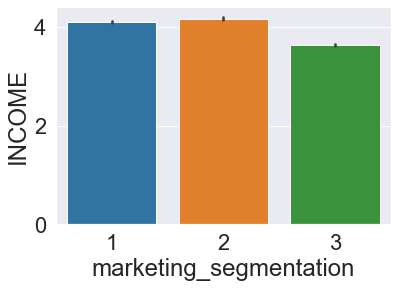

In [235]:
sns.barplot(x="marketing_segmentation",
             y="INCOME",
             data=data,palette="tab10")

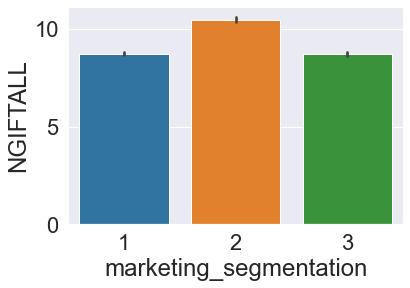

In [236]:
sns.barplot(x="marketing_segmentation",
             y="NGIFTALL",
             data=data,palette="tab10")

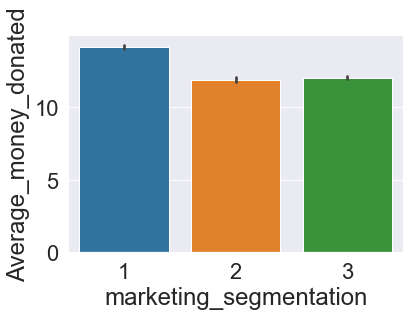

In [237]:
sns.barplot(x="marketing_segmentation",
             y="Average_money_donated",
             data=data,palette="tab10")

In [239]:
interests.replace({"Y":1, " ":0}, inplace=True)

In [240]:
interests["labels"]=labels2
interests["marketing_segmentation"]=interests["labels"]
interests["marketing_segmentation"].replace({0:2,1:1,2:3,3:3,4:1,5:2,6:2,7:3,8:1,9:2,10:3,11:3,12:1,13:3,14:1},inplace=True)

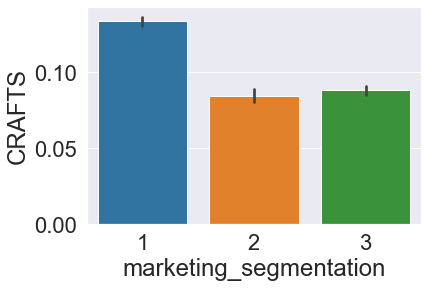

In [241]:
sns.barplot(x="marketing_segmentation",
             y="CRAFTS",
             data=data,palette="tab10")

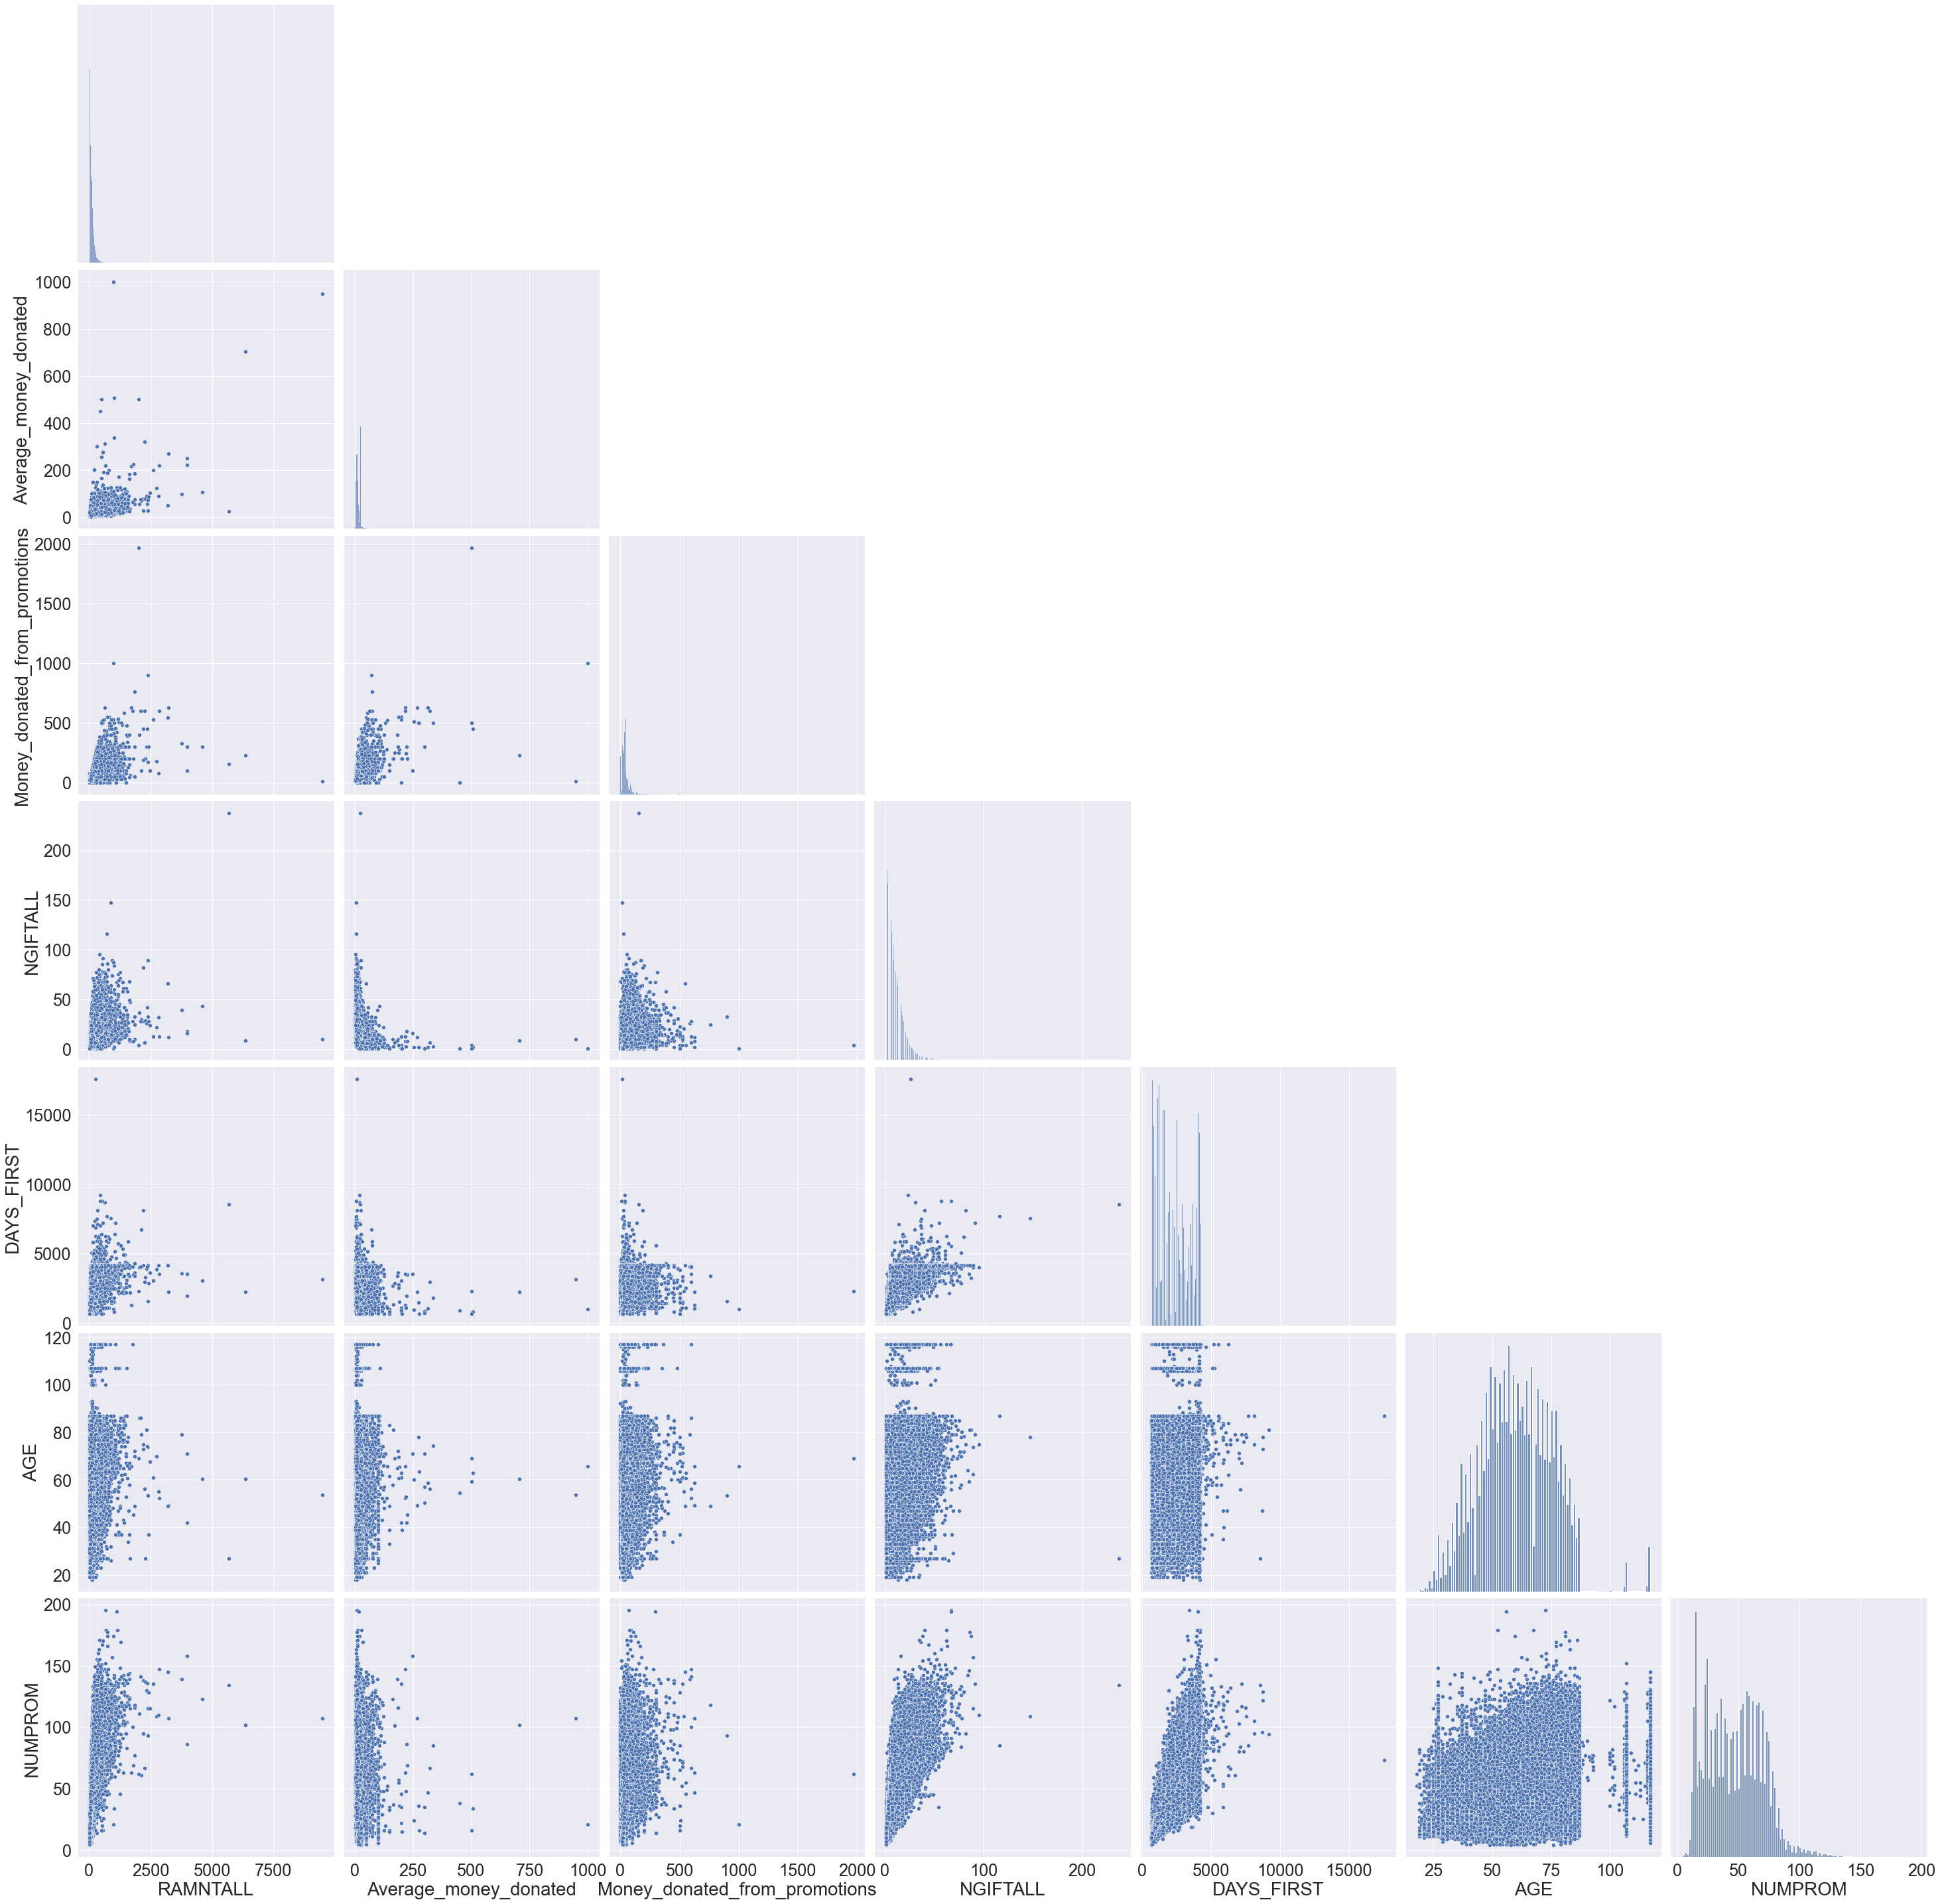

In [242]:
metric_features3=["RAMNTALL","Average_money_donated","Money_donated_from_promotions","NGIFTALL","DAYS_FIRST","AGE","NUMPROM"]
sns.set(font_scale=2.3)
g = sns.PairGrid(data[metric_features3],diag_sharey=False, corner=True,height=20,aspect=1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, edgecolor="w")
g.fig.set_size_inches(w=40, h=40)

In [249]:
population= zipfile.groupby('state_id',as_index=False)['population'].sum()
#the zipfile is the same used in the State section when we wanted to check if the zipcodes where correlated to the State name

state=data['STATE'].value_counts().index.tolist()
df=pd.DataFrame(state, columns=['STATE'])
df['value']=data['STATE'].value_counts().tolist()
df

ranking=pd.merge(left=df, right=population, right_on='state_id', left_on='STATE')


ranking['ratio']=round((ranking['value'] / ranking['population'])*100,5)


fig = px.choropleth(ranking,  # Input Pandas DataFrame
                    locations="STATE",  # DataFrame column with locations
                    color= "ratio",  # DataFrame column with color values
                    hover_name="STATE", # DataFrame column hover info
                    locationmode = 'USA-states', color_continuous_scale='reds') # Set to plot as US States
fig.update_layout(
    title_text = 'State Rankings', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen